<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# ⛽ Fuel efficiency Prediction

Provided with the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset, we will predict the **fuel efficiency** of the late-1970s and early 1980s automobiles, leveraging features such as cylinders, displacement, horsepower, weight, etc. 

It is a very small dataset and there are only a few features. We will first build a linear model and a neural network, evaluate their performances, track our experiment runs and inspect the logs using MLflow, and apply [TPOT](https://github.com/EpistasisLab/tpot) to see how it can be used to search over many ML model architectures, followed by explaining the model with SHAP.

# 📚 Learning Objectives

By the end of this session, you will be able to

- understand the core building blocks of a neural network
- understand what dense and activation layers do
- build, train, and evaluate neural networks
- track tensorflow experiments with MLflow, access information of runs programmatically and with its tracking ui
- perform AutoML to search for optimal tree-based pipeline for a regression task 

Note: [State of Data Science and Machine Learning 2021](https://www.kaggle.com/kaggle-survey-2021) by Kaggle shows that the most commonly used algorithms were linear and logtistic regressions, followed closely by decision trees, random forests, and gradient boosting machines (are you surprised?). Multilayer perceptron, or artificial neural networks are not yet the popular tools for tabular/structured data; see more technical reasons in papers: [Deep Neural Networks and Tabular Data: A Survey](https://arxiv.org/abs/2110.01889), [Tabular Data: Deep Learning is Not All You Need](https://arxiv.org/abs/2106.03253). For this assignment, the main purpose is for you to get familiar with the basic building blocks in constructing neural networks before we dive into more specialized neural network architectures.


**IMPORTANT**

You only need to run the following cells if you're completing the assignment in Google Collab. If you've already installed these libraries locally, you can skip installing these libraries.

In [1]:
!export PATH=/Library/TeX/texbin:$PATH

In [1]:
# this notebook run local - I did the prework provided in github

In [ ]:
# Connect colab to your Google Drive
#from google.colab import drive #coomented out
#drive.mount('/content/drive') #out

In [2]:
!pip install daal==2021.4.0 #needed to do the sns

  Using cached daal-2021.4.0-py2.py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.whl (189.9 MB)
  Using cached tbb-2021.8.0-py2.py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.whl (1.0 MB)
  Attempting uninstall: tbb
    Found existing installation: TBB 0.2
ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [3]:
!pip install -q pluggy==1.0.0

In [4]:
!pip install -q seaborn # pairplot
!pip install -q tpot  # automl

!pip install -q mlflow # tracking
!pip install -q pyngrok # workaround to run mlflow ui in colab
!pip install -q shap

In [5]:
## one errors - most of the stuff should run

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [7]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.__version__)

2023-01-31 18:27:06.927507: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0


# Task 1 - Data: Auto MPG dataset

0. Start MLflow's automatic logging using library-specific autolog calls for tensorflow: logging metrics, parameters, and models without the need for explicit log statements. 
    
    We will get into more details using **MLflow** after completing our experiment.

In [8]:
import mlflow
mlflow.tensorflow.autolog() # MLflow Autologging
# typed conda install -c conda-forge mlflow at the terminal prompt

1. The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/). First download and import the dataset using `pandas`:


In [9]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = [
  'MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
  'Acceleration', 'Model Year', 'Origin'
  ]

dataset = pd.read_csv(url, names=column_names, na_values='?', 
                      comment='\t', sep=' ', skipinitialspace=True)

In [10]:
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1

2. The dataset contains a few unknown values, we drop those rows to keep this initial tutorial simple. Use `pd.DataFrame.dropna()`:

In [11]:
dataset.shape

(398, 8)

In [12]:
dataset = dataset.dropna() # YOUR CODE HERE

In [13]:
dataset.shape

(392, 8)

3. The `"Origin"` column is categorical, not numeric. So the next step is to one-hot encode the values in the column with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

In [14]:
dataset['Origin'] = dataset['Origin'].replace({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [15]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Europe  Japan  USA  
393          82       0      0    1  
394          82       1      0    0  
395          82       0      0    1  
396          82       0      0    1  
397          82       0      0    1

4. Split the data into training and test sets. To reduce the module importing overhead, instead of `sklearn.model_selection.train_test_split()`, use `pd.DataFrame.sample()` to save 80% of the data aside to `train_dataset`, set the random state to be 0 for reproducibility. 

   Then use `pd.DataFrame.drop()` to obtain the `test_dataset`.

In [16]:
train_dataset = dataset.sample(frac=.8,random_state=0) # YOUR CODE HERE
test_dataset = dataset.drop(train_dataset.index)# YOUR CODE HERE

5. Review the pairwise relationships of a few pairs of columns from the training set. 
   
   The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

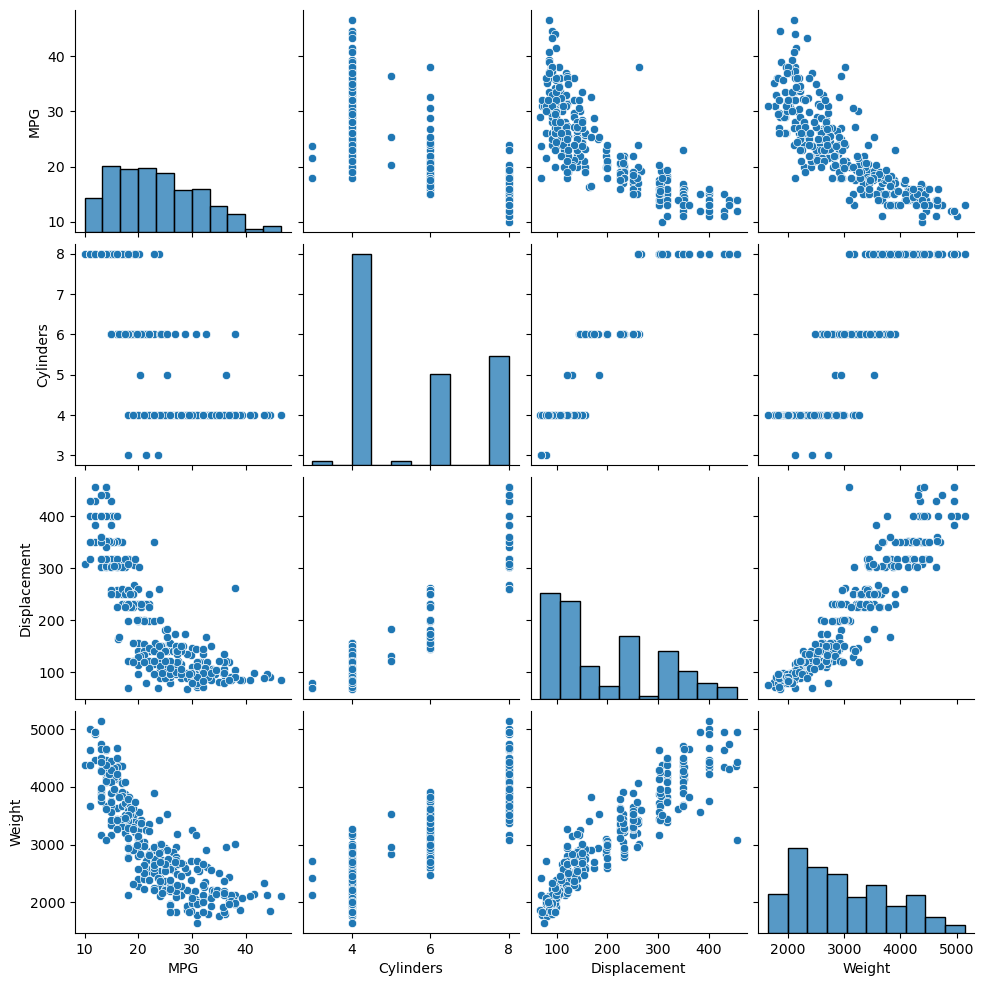

In [17]:
###########  DEBUG THIS ##########
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']]); #####

Let's also check the overall statistics. Note how each feature covers a very different range:

In [18]:
train_dataset.describe().transpose()

count         mean         std     min      25%     50%  \
MPG           314.0    23.310510    7.728652    10.0    17.00    22.0   
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   

                  75%     max  
MPG             28.95    46.6  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acceleration    17.20    24.8  
Model Year      79.00    82.0  
Europe           0.00     1.0  
Japan            0.00     1.0  
USA              1.00     1.0

6. Split features from labels. 
  This means, separate the target value(also called"label") from the features. 
  Label is the value that you will train the model to predict.

In [19]:
train_features = train_dataset.copy() # hard copy of the dataframe - original stays as is
test_features = test_dataset.copy() # YOUR CODE HERE

train_labels = train_features.pop('MPG') # this removes the MPG variable from train_features 
test_labels = test_features.pop('MPG') # and moves it in the train_labels --> elegant

# Task 2 - Normalization Layer

It is good practice to normalize features that use different scales and ranges. Although a model *might* converge without feature normalization, normalization makes training much more stable.

Similar to scikit-learn, tensorflow.keras offers a list of [preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) so that you can build and export models that are truly end-to-end.

1. The Normalization layer ([`tf.keras.layers.Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization) is a clean and simple way to add feature normalization into your model. The first step is to create the layer:

In [20]:
normalizer = tf.keras.layers.Normalization() # YOUR CODE HERE

2. Then, fit the state of the preprocessing layer to the data by calling [`Normalization.adapt`](https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method):

In [34]:
normalizer.adapt(train_features) # adapt blank stuff

We can see the feature mean and variance are stored in the layer:

In [35]:
print(f'feature mean: {normalizer.mean.numpy().squeeze()}\n')
print(f'feature variance: {normalizer.variance.numpy().squeeze()}')

feature mean: [   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]

feature variance: [     2.88   10850.413   1446.699 709896.9        7.755     13.467
      0.147      0.158      0.235]


When the layer is called, it returns the input data, with each feature independently normalized:

In [36]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Task 3 - Linear Regression 📈

Before building a deep neural network model, start with linear regression using all the features.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which [represents a sequence of steps](https://www.tensorflow.org/guide/keras/sequential_model).

There are two steps in this multivariate linear regression model:

- Normalize all the input features using the `tf.keras.layers.Normalization` preprocessing layer. You have defined this earlier as `normalizer`.
- Apply a linear transformation ($y = mx+b$ where $m$ is a matrix and $b$ is a vector.) to produce one output using a linear layer ([`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

1. Build the Keras Sequential model:

In [37]:
linear_model = tf.keras.Sequential([
                        normalizer,
                        tf.keras.layers.Dense(units=1) # could add activation='linear')
                                    ])

In [38]:
linear_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


2. This model will predict `'MPG'` from all features in `train_features`. Run the untrained model on the first 10 data points / rows using `Model.predict()`. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

In [39]:
linear_model.predict(train_features[:10])## YOUR CODE HERE

1/1 [==============================] - 0s 61ms/step


array([[ 0.109],
       [ 0.373],
       [-1.933],
       [ 1.091],
       [ 1.507],
       [ 0.171],
       [ 1.69 ],
       [ 1.625],
       [-0.446],
       [ 0.566]], dtype=float32)

3. When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y = mx + b$) have a shape of (9, 1):

In [40]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.429],
       [ 0.704],
       [-0.504],
       [-0.52 ],
       [ 0.124],
       [ 0.327],
       [ 0.53 ],
       [ 0.432],
       [ 0.251]], dtype=float32)>

4. Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized and how (using the `tf.keras.optimizers.Adam`).

  Here's a list of built-in loss functions in [`tf.keras.losses`](https://www.tensorflow.org/api_docs/python/tf/keras/losses). For regression tasks, [common loss functions](https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3) include mean squared error (MSE) and mean absolute error (MAE). Here,  MAE is preferred such that the model is more robust against outliers. 

  For optimizers, gradient descent (check this video [Gradient Descent, Step-by-Step](https://www.youtube.com/watch?v=sDv4f4s2SB8) for a refresher) is the preferred way to optimize neural networks and many other machine learning algorithms. Read [an overview of graident descent optimizer algorithms](https://ruder.io/optimizing-gradient-descent/) for several popular gradient descent algorithms. Here, we use the popular [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), and set the learning rate at 0.1 for faster learning.  

In [41]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = .1), # YOUR CODE HERE
    loss=tf.keras.losses.MeanAbsoluteError() # YOUR CODE HERE
    )

5. Use Keras `Model.fit` to execute the training for 100 epochs, set the verbose to 0 to suppress logging and keep 20% of the data for validation:

In [42]:
%%time
history = linear_model.fit(x=train_features,y=train_labels,epochs=100, validation_split=.2) # YOUR CODE HERE

2023/01/31 19:14:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '416c1ca789a646cba1604f5d1ec01953', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/100
1/8 [==>...........................] - ETA: 5s - loss: 22.7974WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0022s vs `on_train_batch_end` time: 0.0034s). Check your callbacks.


8/8 [==============================] - 1s 44ms/step - loss: 22.9780 - val_loss: 22.8973
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 22.0896 - val_loss: 22.1690
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 21.2538 - val_loss: 21.4801
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 20.4357 - val_loss: 20.7823
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 19.6283 - val_loss: 20.0840
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 18.7895 - val_loss: 19.3546
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 17.9768 - val_loss: 18.5769
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 17.1567 - val_loss: 17.8816
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 16.3554 - val_loss: 17.1801
Epoch 10/100
8/8 [==============================] - 0s 10ms/step - loss: 15.5110 - val_loss: 16.4358
Epoch 11/10

Epoch 84/100
8/8 [==============================] - 0s 10ms/step - loss: 2.4927 - val_loss: 2.4614
Epoch 85/100
8/8 [==============================] - 0s 8ms/step - loss: 2.5247 - val_loss: 2.4874
Epoch 86/100
8/8 [==============================] - 0s 8ms/step - loss: 2.5028 - val_loss: 2.5083
Epoch 87/100
8/8 [==============================] - 0s 9ms/step - loss: 2.5116 - val_loss: 2.4441
Epoch 88/100
8/8 [==============================] - 0s 9ms/step - loss: 2.4629 - val_loss: 2.5328
Epoch 89/100
8/8 [==============================] - 0s 11ms/step - loss: 2.5012 - val_loss: 2.4583
Epoch 90/100
8/8 [==============================] - 0s 10ms/step - loss: 2.4791 - val_loss: 2.4591
Epoch 91/100
8/8 [==============================] - 0s 8ms/step - loss: 2.4631 - val_loss: 2.4995
Epoch 92/100
8/8 [==============================] - 0s 8ms/step - loss: 2.4706 - val_loss: 2.4477
Epoch 93/100
8/8 [==============================] - 0s 8ms/step - loss: 2.4956 - val_loss: 2.4648
Epoch 94/100
8/8 

2023/01/31 19:15:05 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: tuple index out of range
2023/01/31 19:15:05 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/dx/8bzgllmx7g13k02q2z8660kr0000gq/T/tmp06tnowpp/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/dx/8bzgllmx7g13k02q2z8660kr0000gq/T/tmp06tnowpp/model/data/model/assets
2023/01/31 19:15:05 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/dx/8bzgllmx7g13k02q2z8660kr0000gq/T/tmp06tnowpp/model, flavor: tensorflow), fall back to return ['tensorflow==2.11.0']. Set logging level to DEBUG to see the full traceback.


CPU times: user 8.24 s, sys: 846 ms, total: 9.09 s
Wall time: 10.7 s


6. Visualize the model's training progress using the stats stored in the `history` object:

In [44]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss  val_loss  epoch
95  2.471398  2.474460     95
96  2.477598  2.491461     96
97  2.473082  2.457406     97
98  2.499563  2.455935     98
99  2.507488  2.458402     99

In [45]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

Use `plot_loss(history)` provided to visualize the progression in loss function for training and validation data sets. 

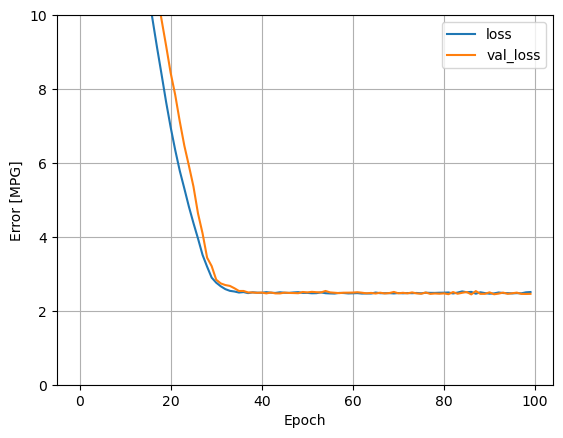

In [46]:
plot_loss(history)# YOUR CODE HERE

7. Collect the results on the test set for later using [`Model.evaluate()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate)

In [47]:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(x=test_features, y=test_labels)# YOUR CODE HERE

3/3 [==============================] - 0s 6ms/step - loss: 2.4612


In [48]:
test_results

{'linear_model': 2.4612009525299072}

# Task 4 - Regression with a Deep Neural Network (DNN)

You just implemented a linear model for multiple inputs. Now, you are ready to implement multiple-input DNN models.

The code is very similar except the model is expanded to include some "hidden" **non-linear** layers. The name "hidden" here just means not directly connected to the inputs or outputs.

* The normalization layer, as before (with `normalizer` for a multiple-input model).
* Two hidden, non-linear, [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers with the ReLU (`relu`) activation function nonlinearity. One way is to set parameter `activation` inside `Dense` Set the number of neurons at each layer to be 64. 
* A linear `Dense` single-output layer. 



1. Include the model and `compile` method in the `build_and_compile_model` function below. 

In [49]:
def build_and_compile_model(norm):
    model = tf.keras.Sequential([
        norm,
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1),        
    ]) # YOUR CODE HERE
    
    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam())
    return model

2. Create a DNN model with `normalizer` (defined earlier) as the normalization layer:



In [50]:
dnn_model = build_and_compile_model(normalizer)# YOUR CODE HERE

3. Inspect the model using `Model.summary()`. This model has quite a few more trainable parameters than the linear models:

In [51]:
dnn_model.summary()# YOUR CODE HERE

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 64)                640       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


4. Train the model with Keras `Model.fit`:

In [52]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

2023/01/31 19:28:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '74c24586ef67442d973256f1c6733911', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2023/01/31 19:28:33 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2023/01/31 19:28:33 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference i

INFO:tensorflow:Assets written to: /var/folders/dx/8bzgllmx7g13k02q2z8660kr0000gq/T/tmpubdm01t3/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/dx/8bzgllmx7g13k02q2z8660kr0000gq/T/tmpubdm01t3/model/data/model/assets
2023/01/31 19:28:34 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/dx/8bzgllmx7g13k02q2z8660kr0000gq/T/tmpubdm01t3/model, flavor: tensorflow), fall back to return ['tensorflow==2.11.0']. Set logging level to DEBUG to see the full traceback.


CPU times: user 7.79 s, sys: 659 ms, total: 8.45 s
Wall time: 9.11 s


5. Visualize the model's training progress using the stats stored in the history object. 

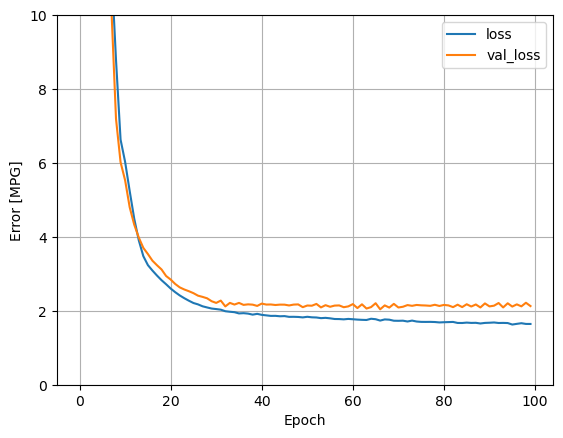

In [53]:
plot_loss(history)

Do you think the DNN model is overfitting? What gives away? 

  As the validation does not keep improving and the training keeps improving it is an ok model
  If the training and validation were both improving that would mean there is no difference and then it is overfitting

6. Let's save the results for later comparison.

In [54]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [55]:
test_results

{'linear_model': 2.4612009525299072, 'dnn_model': 1.6599880456924438}

# Task 5 - Make Predictions 🔮

1. Since both models have been trained, we can review their test set performance:

In [56]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

Mean absolute error [MPG]
linear_model                   2.461201
dnn_model                      1.659988

These results match the validation error observed during training.

2. We can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss. Use `.flatten()`.

3/3 [==============================] - 0s 2ms/step


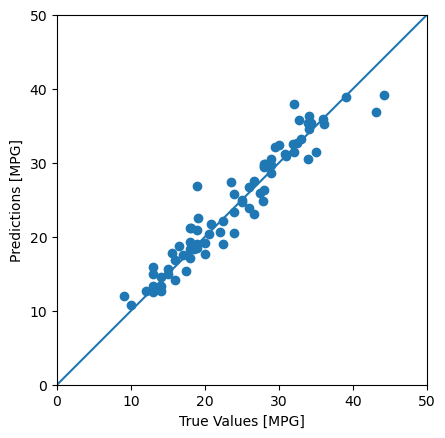

In [57]:
test_predictions = dnn_model.predict(test_features) # YOUR CODE HERE

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


3. It appears that the model predicts reasonably well. Now, check the error distribution:

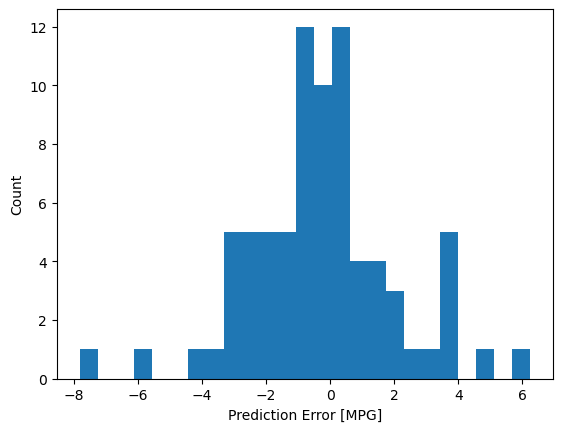

In [58]:
error = (test_labels - test_predictions.squeeze()) # YOUR CODE HERE
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

4. Save it for later use with `Model.save`:

In [59]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


INFO:tensorflow:Assets written to: dnn_model/assets


5. Reload the model with `Model.load_model`; it gives identical output:

In [60]:
from tensorflow import keras
reloaded = keras.models.load_model('dnn_model') # YOUR CODE HERE

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [61]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

Mean absolute error [MPG]
linear_model                   2.461201
dnn_model                      1.659988
reloaded                       1.659988

# Task 6 - Nonlinearity

We mentioned that the `relu` activation function introduce non-linearity; let's visualize it. Since there are six numerical features and 1 categorical features, it is impossible to plot all the dimensions on a 2D plot; we need to simplify/isolate it. 

Note: in this task, code is provided; the focus in on understanding. 

1. We focus on the relationship between feature `Displacement` and target `MPG`. 
  
  To do so, create a new dataset of the same size as `train_features`, but all other features are set at their median values; then set the `Displacement` between 0 and 500. 

In [62]:
fake = np.outer(np.ones(train_features.shape[0]), train_features.median())
fake = pd.DataFrame(fake, columns = train_features.columns)
fake.Displacement = np.linspace(0, 500, train_features.shape[0])

2. Create a plotting function to:

    a) visualize real values between `Displacement` and `MPG` from the training dataset in scatter plot 
    
    b) overlay the predicted MPG from Displacement varying from 0 to 500, but holding all other features constant. 

In [63]:
def plot_displacement(x, y):
    plt.scatter(train_features['Displacement'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Displacement')
    plt.ylabel('MPG')
    plt.legend()

3. Visualize predicted MPG using the linear model.

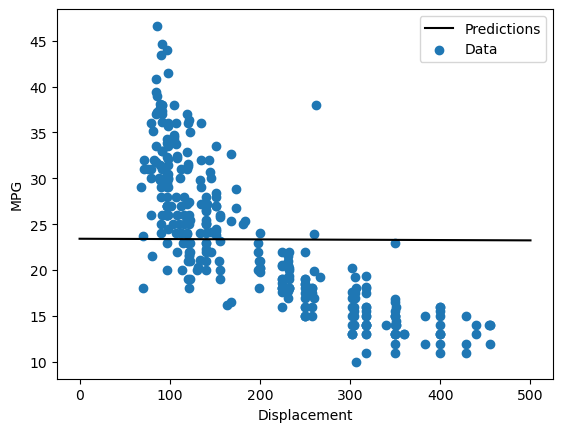

In [64]:
plot_displacement(fake.Displacement, linear_model(fake))

4. Visualize predicted MPG using the neural network model. Do you see an improvement/non-linearity from the linear model? 
### yes it imitates the trend of the results

10/10 [==============================] - 0s 3ms/step


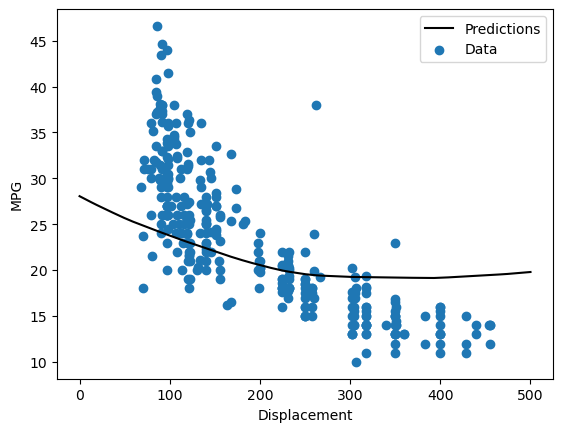

In [65]:
plot_displacement(fake.Displacement, dnn_model.predict(fake)) 

5. What are the other activation functions? Check the list of [activations](https://www.tensorflow.org/api_docs/python/tf/keras/activations). 
  
  Optional. Modify the DNN model with a different activation function, and fit it on the data; does it perform better? 

### Trying with Tanh

In [66]:
def build_and_compile_model2(norm):
    model = tf.keras.Sequential([
        norm,
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(1),        
    ]) 

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam())
    return model

dnn_model2 = build_and_compile_model2(normalizer)
dnn_model2.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [67]:
%%time
history2 = dnn_model2.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

2023/01/31 20:05:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '028b8d02ca534781996b9d0258219ec8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2023/01/31 20:05:49 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2023/01/31 20:05:49 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference i

INFO:tensorflow:Assets written to: /var/folders/dx/8bzgllmx7g13k02q2z8660kr0000gq/T/tmpzz_6bi0u/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/dx/8bzgllmx7g13k02q2z8660kr0000gq/T/tmpzz_6bi0u/model/data/model/assets
2023/01/31 20:05:50 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/dx/8bzgllmx7g13k02q2z8660kr0000gq/T/tmpzz_6bi0u/model, flavor: tensorflow), fall back to return ['tensorflow==2.11.0']. Set logging level to DEBUG to see the full traceback.


CPU times: user 7.6 s, sys: 633 ms, total: 8.23 s
Wall time: 8.1 s


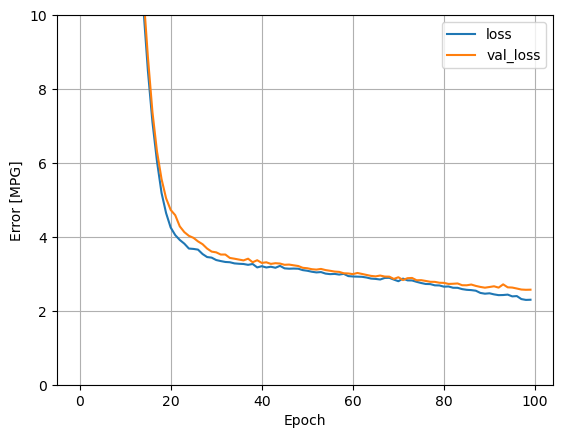

In [68]:
plot_loss(history2)

In [69]:
test_results['dnn_model2'] = dnn_model2.evaluate(test_features, test_labels, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

Mean absolute error [MPG]
linear_model                   2.461201
dnn_model                      1.659988
reloaded                       1.659988
dnn_model2                     2.289334

In [70]:
dnn_model2.save('dnn_model2')

INFO:tensorflow:Assets written to: dnn_model2/assets


INFO:tensorflow:Assets written to: dnn_model2/assets


6. Overfitting is a common problem for DNN models, how should we deal with it? Check [Regularizers](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers) on tf.keras. Any other techiniques that are invented for neural networks?

# Task 7 - MLflow Tracking

In this task, we briefly explore [MLflow Tracking](https://www.mlflow.org/docs/latest/tracking.html#tracking), one of four primary functions that MLflow offers for managing the end-to-end machine learning lifecycle. We will access the information runs programmatically in python and then set up the MLflow UI for easy interaction.

1. Experiments.

    MLflow Tracking is organized around the concept of `runs`, which are executions of some piece of modeling code; and runs are organized into experiments. 

    We set the auto logging in the beginning, we can verify that
    - there is one experiment
    - its name is `0`
    - all of its artifacts are stored at `file:///content/mlruns/0` in Google Drive.

In [71]:
from mlflow import MlflowClient
client = MlflowClient()
client.search_experiments()  
#client.list_experiments() old code

[<Experiment: artifact_location='file:///Users/Gilles/Documents/GitHub/week-07-intro-dl/nb/mlruns/0', creation_time=1675008942937, experiment_id='0', last_update_time=1675008942937, lifecycle_stage='active', name='Default', tags={}>]

2. Runs. 

   List information for runs that are under experiment '0' using [`mlflow.list_run_infos()`](https://www.mlflow.org/docs/latest/python_api/mlflow.html#mlflow.list_run_infos).

In [72]:
client.search_runs('0')# YOUR CODE HERE

[<Run: data=<RunData: metrics={'loss': 2.2992823123931885, 'val_loss': 2.5714523792266846}, params={'batch_size': 'None',
  'class_weight': 'None',
  'epochs': '100',
  'initial_epoch': '0',
  'max_queue_size': '10',
  'opt_amsgrad': 'False',
  'opt_beta_1': '0.9',
  'opt_beta_2': '0.999',
  'opt_clipnorm': 'None',
  'opt_clipvalue': 'None',
  'opt_ema_momentum': '0.99',
  'opt_ema_overwrite_frequency': 'None',
  'opt_epsilon': '1e-07',
  'opt_global_clipnorm': 'None',
  'opt_is_legacy_optimizer': 'False',
  'opt_jit_compile': 'False',
  'opt_learning_rate': '0.001',
  'opt_name': 'Adam',
  'opt_use_ema': 'False',
  'opt_weight_decay': 'None',
  'sample_weight': 'None',
  'shuffle': 'True',
  'steps_per_epoch': 'None',
  'use_multiprocessing': 'False',
  'validation_batch_size': 'None',
  'validation_freq': '1',
  'validation_split': '0.2',
  'validation_steps': 'None',
  'workers': '1'}, tags={'mlflow.autologging': 'tensorflow',
  'mlflow.log-model.history': '[{"run_id": "028b8d02ca53

3. Retrieve the currently active run, i.e., the DNN model. Hint: `mlflow.last_active_run()` 

In [73]:
autolog_run = mlflow.last_active_run()# YOUR CODE HERE

4. Use function `print_auto_logged_info` provided below to fetch the auto logged parameters and metrics for `autolog_run`. 

In [74]:
import json
def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print("run_id: {}".format(r.info.run_id))
    print("artifacts: {}".format(artifacts))
    print("params: {}".format(json.dumps(r.data.params, indent=4)))
    print("metrics: {}".format(r.data.metrics))
    print("tags: {}".format(tags))

In [75]:
print_auto_logged_info(
    autolog_run# YOUR CODE HERE
    ) 

run_id: 028b8d02ca534781996b9d0258219ec8
artifacts: ['model/.DS_Store', 'model/MLmodel', 'model/conda.yaml', 'model/data', 'model/python_env.yaml', 'model/requirements.txt']
params: {
    "opt_ema_momentum": "0.99",
    "opt_epsilon": "1e-07",
    "opt_clipvalue": "None",
    "validation_freq": "1",
    "validation_steps": "None",
    "shuffle": "True",
    "use_multiprocessing": "False",
    "opt_jit_compile": "False",
    "opt_is_legacy_optimizer": "False",
    "sample_weight": "None",
    "initial_epoch": "0",
    "max_queue_size": "10",
    "validation_batch_size": "None",
    "class_weight": "None",
    "opt_beta_2": "0.999",
    "validation_split": "0.2",
    "opt_weight_decay": "None",
    "steps_per_epoch": "None",
    "epochs": "100",
    "opt_name": "Adam",
    "opt_amsgrad": "False",
    "opt_use_ema": "False",
    "opt_clipnorm": "None",
    "batch_size": "None",
    "workers": "1",
    "opt_learning_rate": "0.001",
    "opt_global_clipnorm": "None",
    "opt_ema_overwrite_

5. Optional. Retrieve the best run using [MlflowClient().search_runs()](https://www.mlflow.org/docs/latest/search-runs.html#python).

In [76]:
runs = MlflowClient().search_runs(experiment_ids = ['0'], order_by=['metrics.val_loss']) # YOUR CODE HERE

In [77]:
runs[0]

<Run: data=<RunData: metrics={'loss': 1.6439439058303833, 'val_loss': 2.128159761428833}, params={'batch_size': 'None',
 'class_weight': 'None',
 'epochs': '100',
 'initial_epoch': '0',
 'max_queue_size': '10',
 'opt_amsgrad': 'False',
 'opt_beta_1': '0.9',
 'opt_beta_2': '0.999',
 'opt_clipnorm': 'None',
 'opt_clipvalue': 'None',
 'opt_ema_momentum': '0.99',
 'opt_ema_overwrite_frequency': 'None',
 'opt_epsilon': '1e-07',
 'opt_global_clipnorm': 'None',
 'opt_is_legacy_optimizer': 'False',
 'opt_jit_compile': 'False',
 'opt_learning_rate': '0.001',
 'opt_name': 'Adam',
 'opt_use_ema': 'False',
 'opt_weight_decay': 'None',
 'sample_weight': 'None',
 'shuffle': 'True',
 'steps_per_epoch': 'None',
 'use_multiprocessing': 'False',
 'validation_batch_size': 'None',
 'validation_freq': '1',
 'validation_split': '0.2',
 'validation_steps': 'None',
 'workers': '1'}, tags={'mlflow.autologging': 'tensorflow',
 'mlflow.log-model.history': '[{"run_id": "74c24586ef67442d973256f1c6733911", '
      

6. To see what's logged in the file system `/content/mlruns/`, click tab `files` in the left sidepanel in Colab. For example, 
    ```
    mlruns
    └── 0
        ├── 3a5aebdd35ef46fb8dc35b40e542f0a4
        │   ├── artifacts
        │   ├── meta.yaml
        │   ├── metrics
        │   ├── params
        │   └── tags
        ├── c627bc526c4a4c418a8285627e61a16d
        │   ├── artifacts
        │   ├── meta.yaml
        │   ├── metrics
        │   ├── params
        │   └── tags
        └── meta.yaml

    11 directories, 3 files
    ```

    Inspect the model summary of the DNN model you ran previously; it is located at `artifacts/model_summary.txt` of the corresponding run. Use `cat $filepath`. 

In [88]:
!ls mlruns/0/{runs[0].info.run_id}/artifacts/model_summary.txt

mlruns/0/74c24586ef67442d973256f1c6733911/artifacts/model_summary.txt


In [90]:
!cat mlruns/0/74c24586ef67442d973256f1c6733911/artifacts/model_summary.txt# YOUR CODE HERE (bash)

zsh:1: unknown file attribute: b


### It should show this (taken from collab)

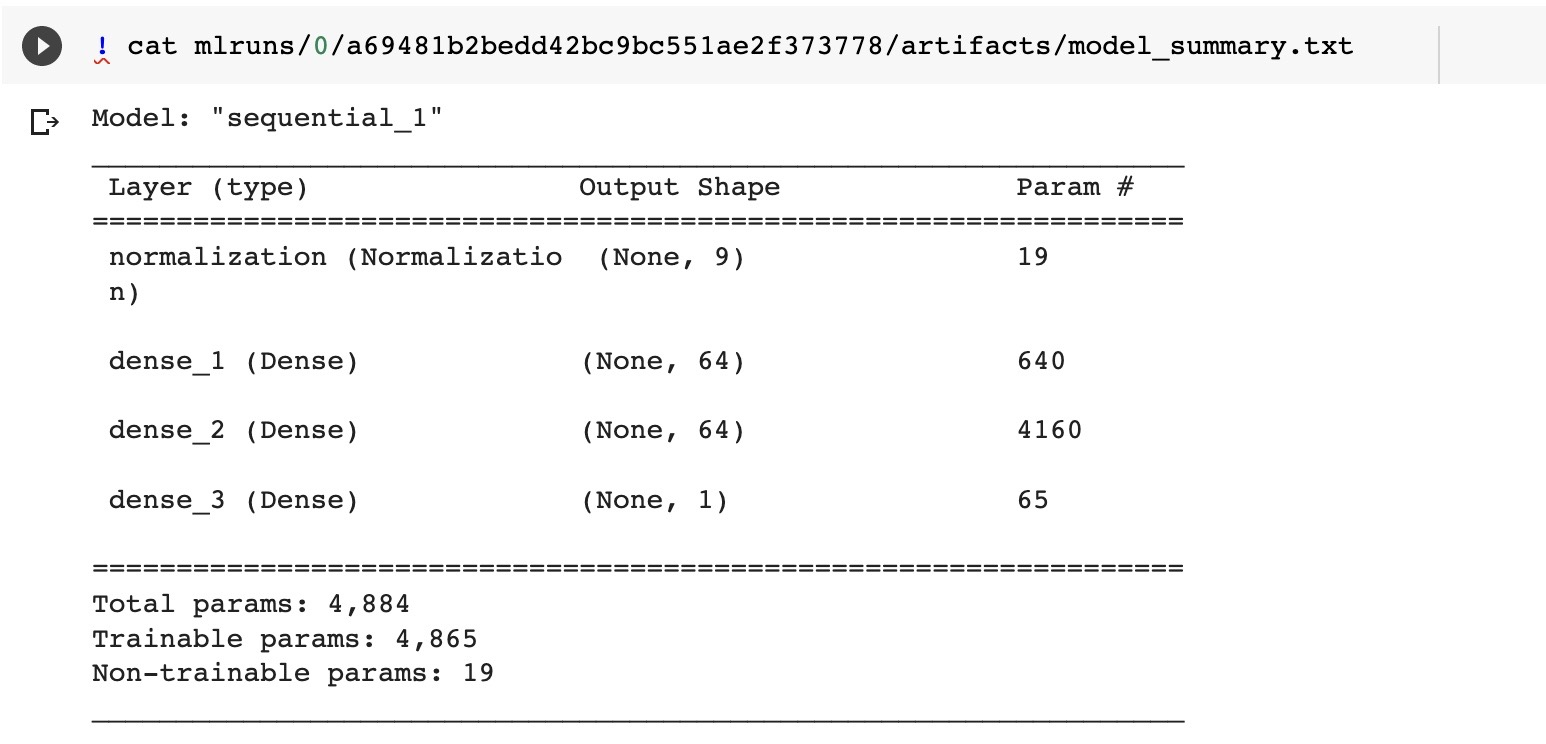

In [98]:
from IPython.display import Image, display
# change the filename to wherever you downloaded/uploaded the file
filename = '../img/summary.jpg'
display(Image(filename=filename))

### The finder that mlflow got all the experiments in mlrun

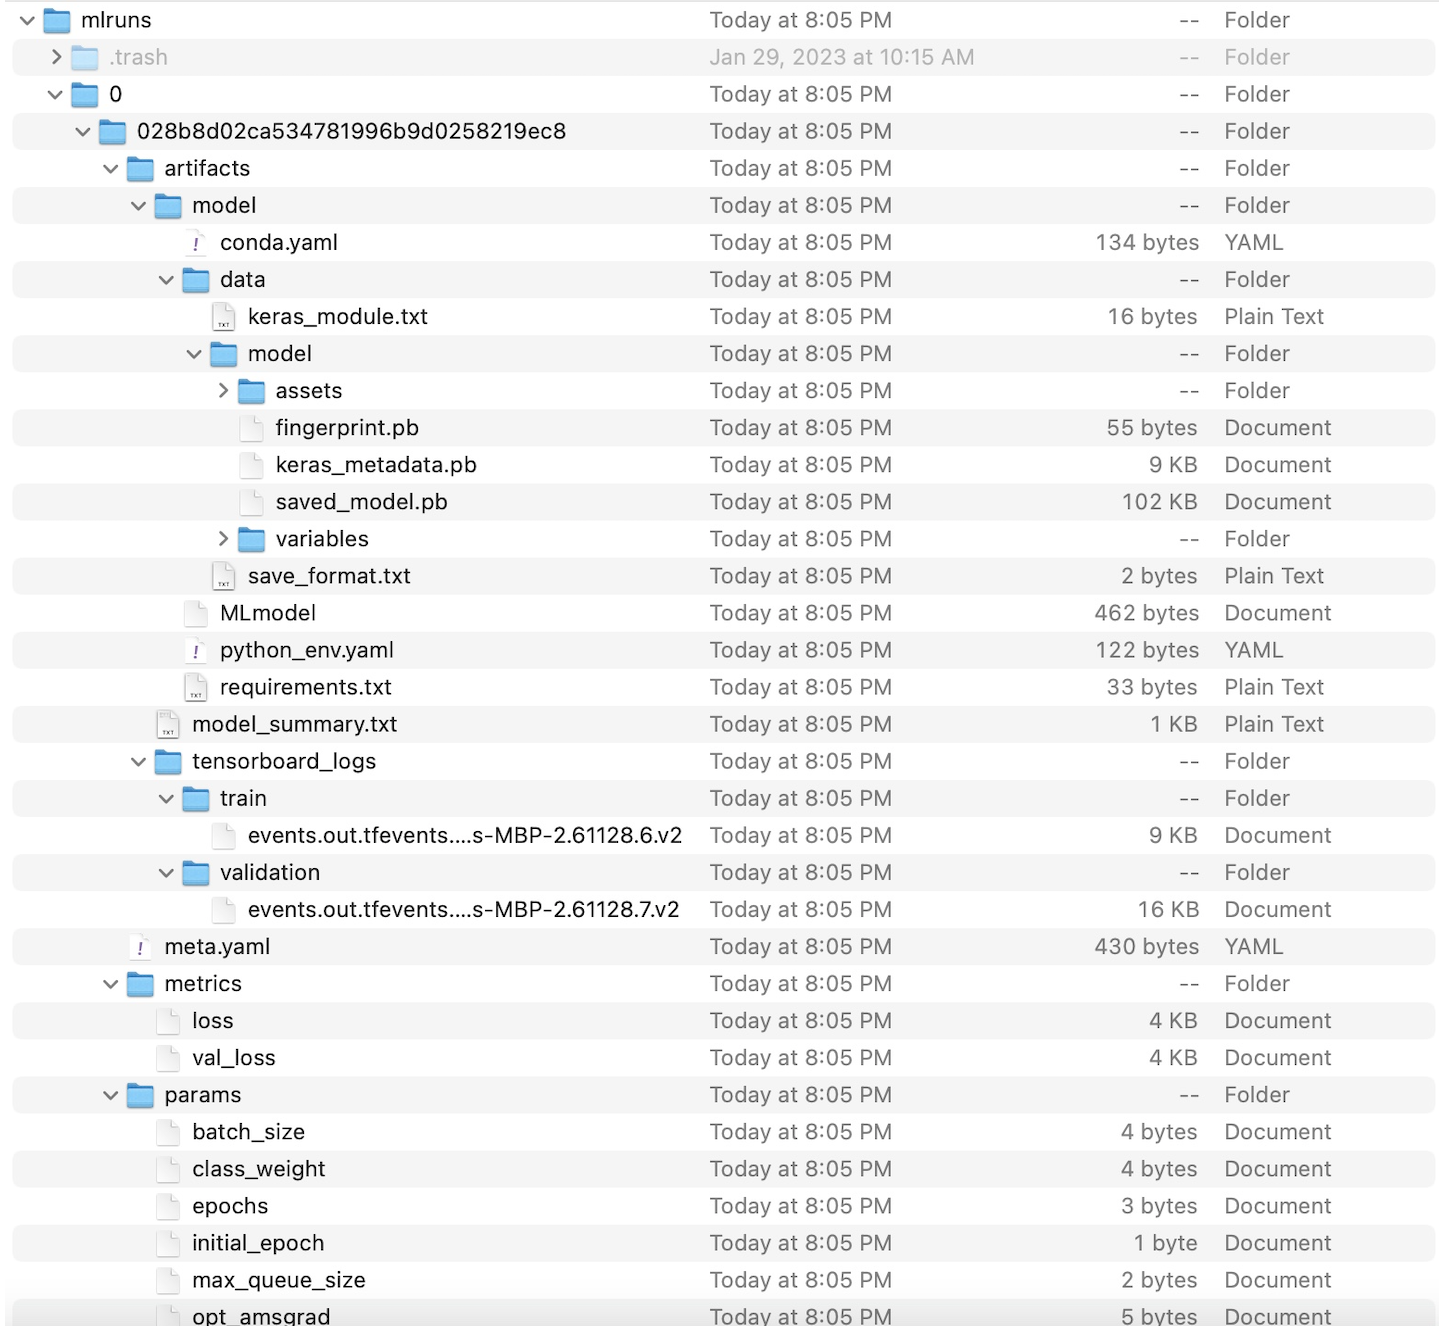

In [91]:
filename = '../img/mlrunpic1.png'
display(Image(filename=filename))

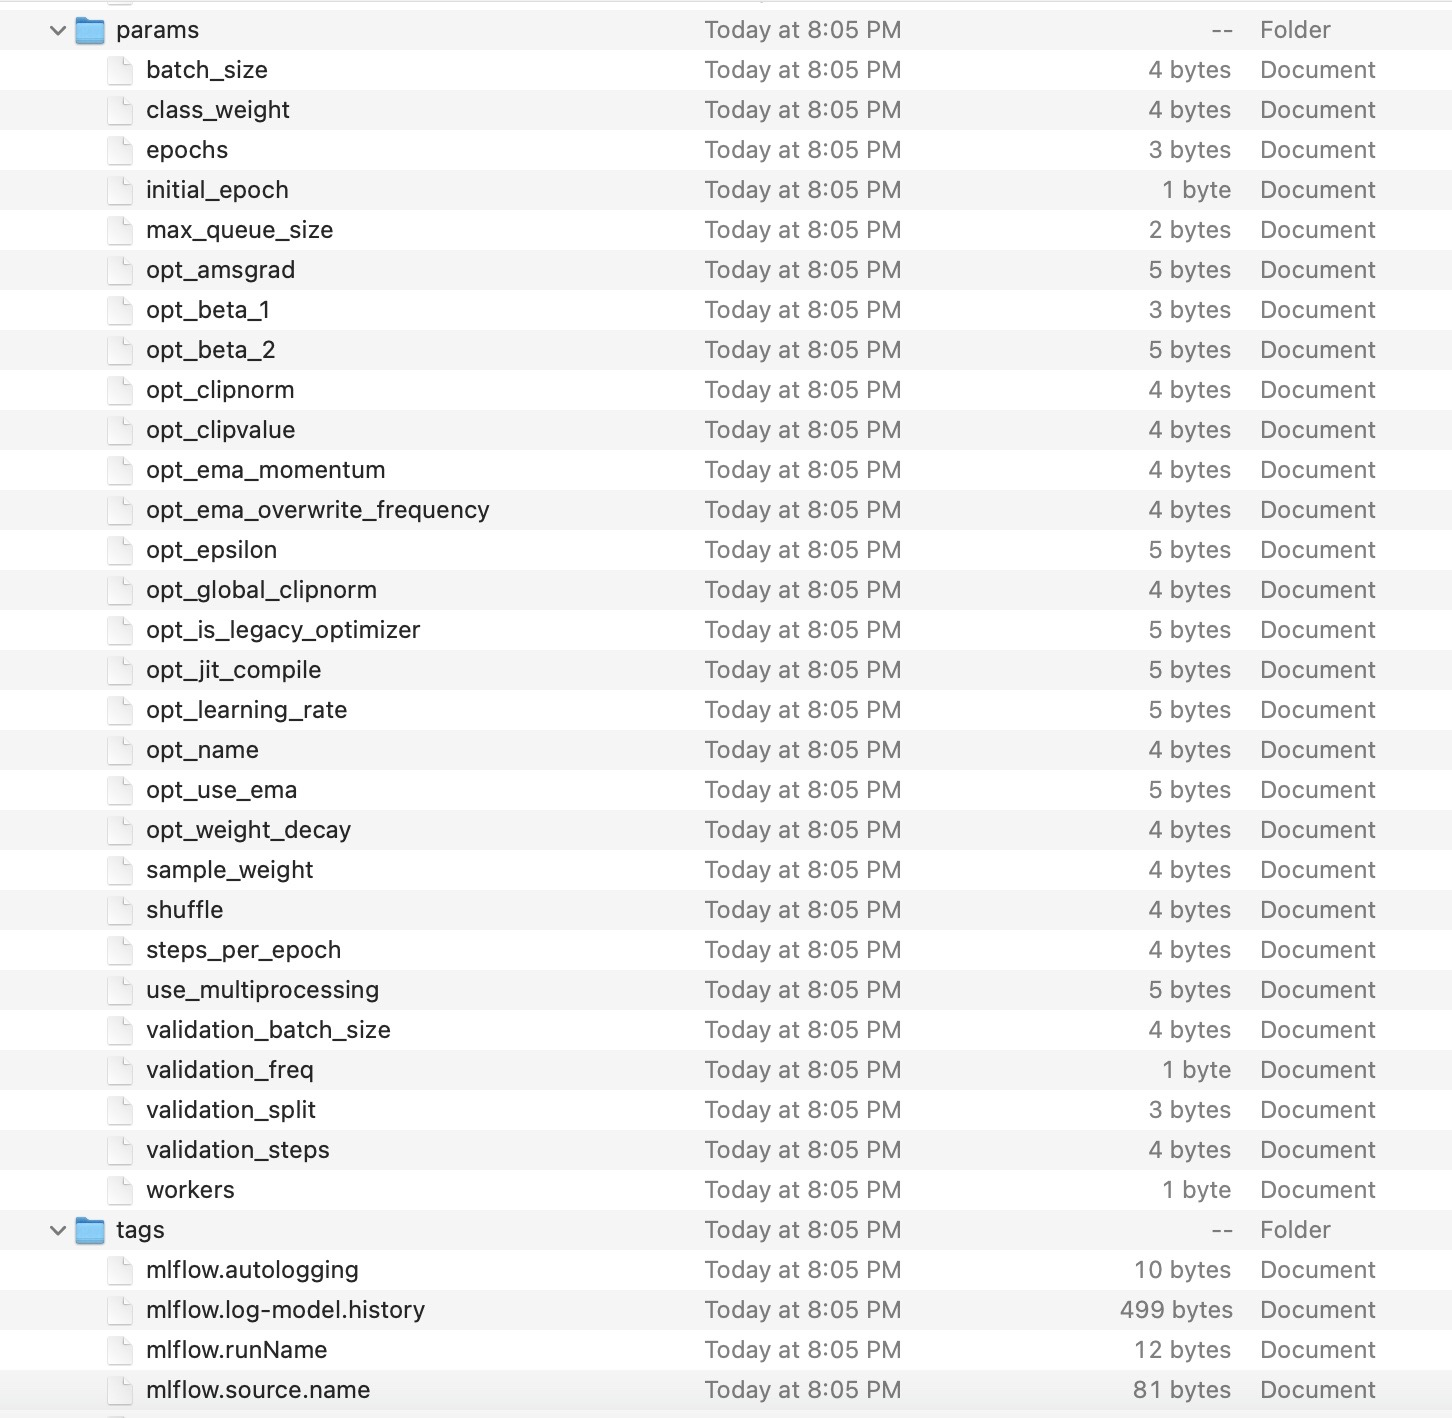

In [92]:
from IPython.display import Image, display
# change the filename to wherever you downloaded/uploaded the file
filename = '../img/mlrunpic2.jpg'
display(Image(filename=filename))

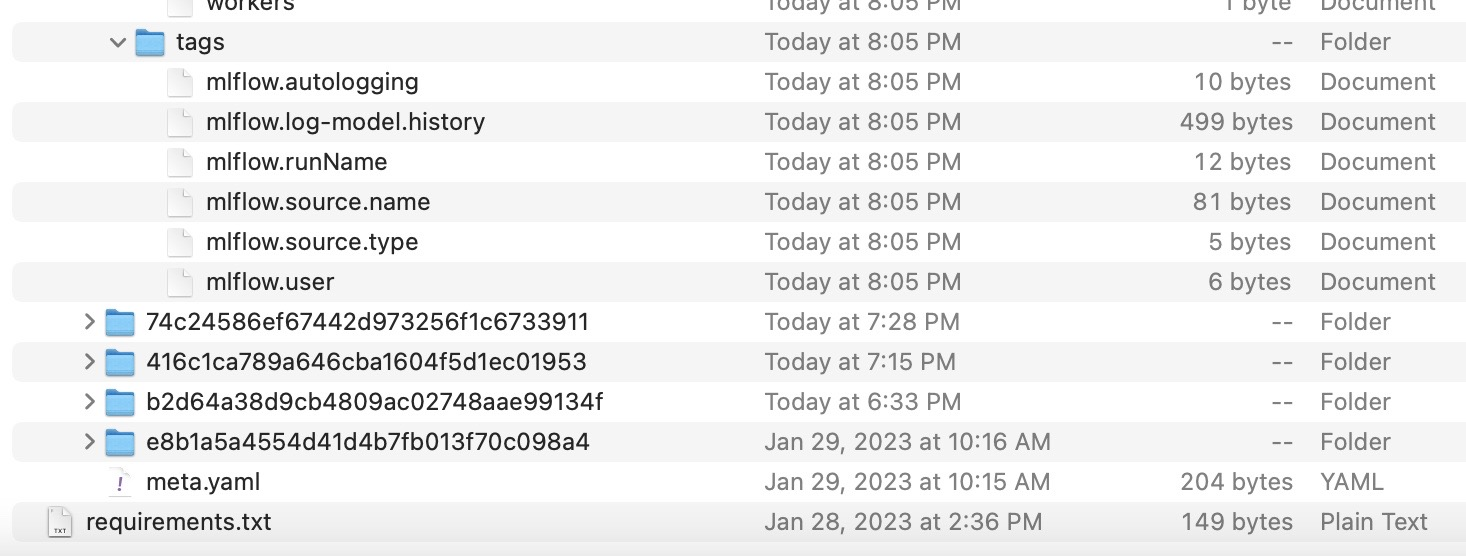

In [94]:
from IPython.display import Image, display
# change the filename to wherever you downloaded/uploaded the file
filename = '../img/mlrunpic3.jpg'
display(Image(filename=filename))
# the 4 next experiments (linear, redo dnn, dnn2)

### Showing what is in dnn

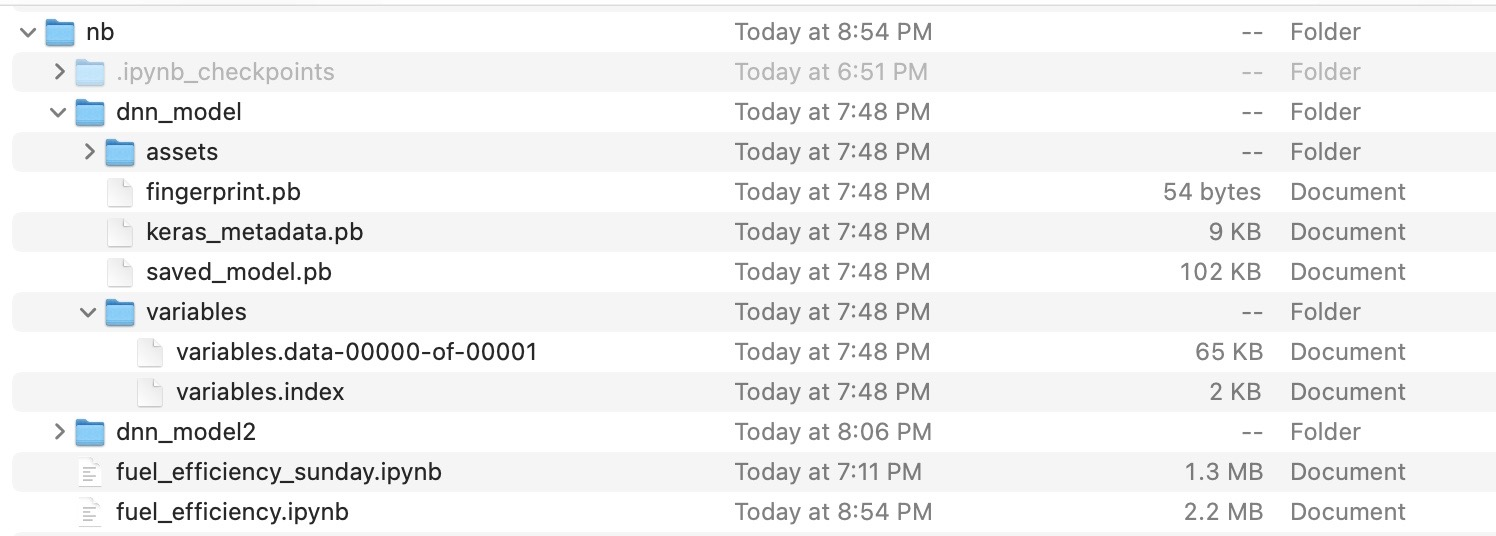

In [97]:
from IPython.display import Image, display
# change the filename to wherever you downloaded/uploaded the file
filename = '../img/dnnModel.jpg'
display(Image(filename=filename))

7. Tracking UI. 

    MLflow provides an UI for us to visualize, search and compare runs, as well as download run artifacts or metadata for analysis in other tools. 

    If your runs are logged to a local mlruns directory, run `mlflow ui` in the directory above it will load the corresponding runs. 
    
    Running localhost server in Colab, however, requires a bit of extra work:
    - set up a free account on [ngrok](https://dashboard.ngrok.com/get-started/setup)
    - retrieve the authtoken from https://dashboard.ngrok.com/auth and update the code cell below
    
   **NOTE**. NEVER share your secrets. Best to keep `NGROK_AUTH_TOKEN` as an environment variable and retrieve it via `os.environ.get("NGROK_AUTH_TOKEN")`.

In [99]:
# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") 

# create remote tunnel using ngrok.com to allow local port access
from pyngrok import ngrok
# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (see Note above)
NGROK_AUTH_TOKEN = "2L0umvOgkhKcI2PiJKkSWQuvvSI_42VfXjNJSxjVrUzCrKyhU"  # YOUR CODE HERE
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

ModuleNotFoundError: No module named 'pyngrok'

[2023-01-31 21:02:50 -0600] [66666] [INFO] Starting gunicorn 20.1.0
[2023-01-31 21:02:50 -0600] [66666] [INFO] Listening at: http://127.0.0.1:5000 (66666)
[2023-01-31 21:02:50 -0600] [66666] [INFO] Using worker: sync
[2023-01-31 21:02:50 -0600] [66669] [INFO] Booting worker with pid: 66669
[2023-01-31 21:02:50 -0600] [66670] [INFO] Booting worker with pid: 66670
[2023-01-31 21:02:50 -0600] [66671] [INFO] Booting worker with pid: 66671
[2023-01-31 21:02:50 -0600] [66672] [INFO] Booting worker with pid: 66672


8. Interact with Tracking UI. 

    Open the link, output from the previous cell. get oriented, `Parameters`, `Metrics`, `Artifacts`, and so on.
    
    When you are done, make sure to terminate the open tunnel:

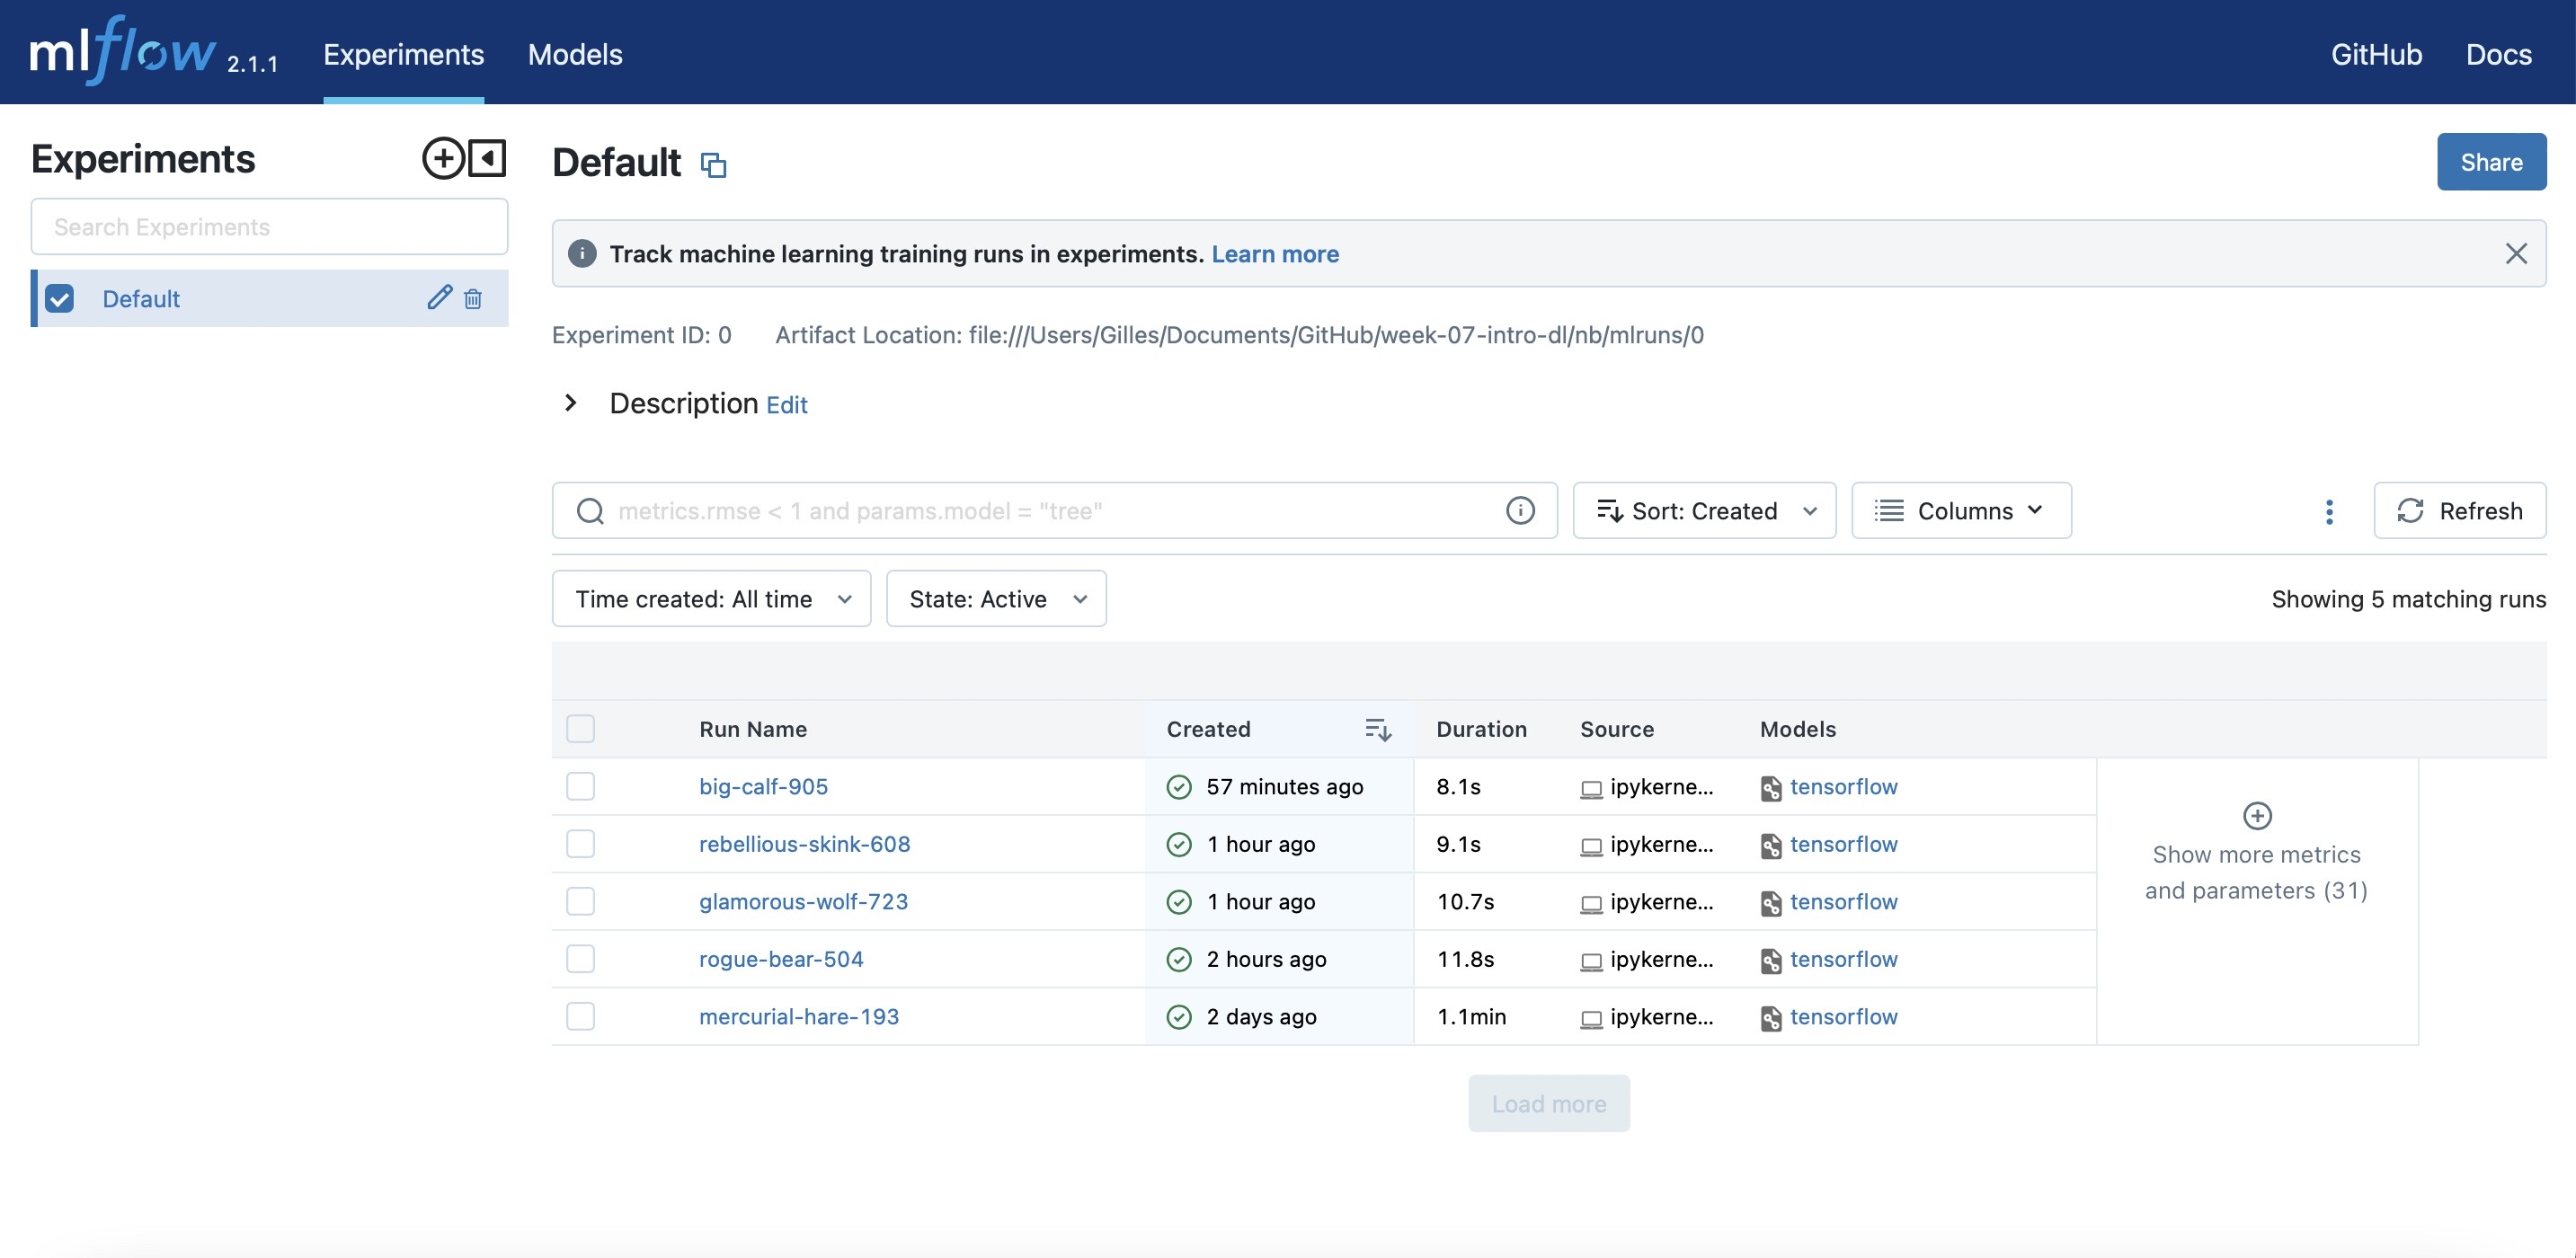

In [102]:
filename = '../img/mlflowexp1.jpg'
display(Image(filename=filename))

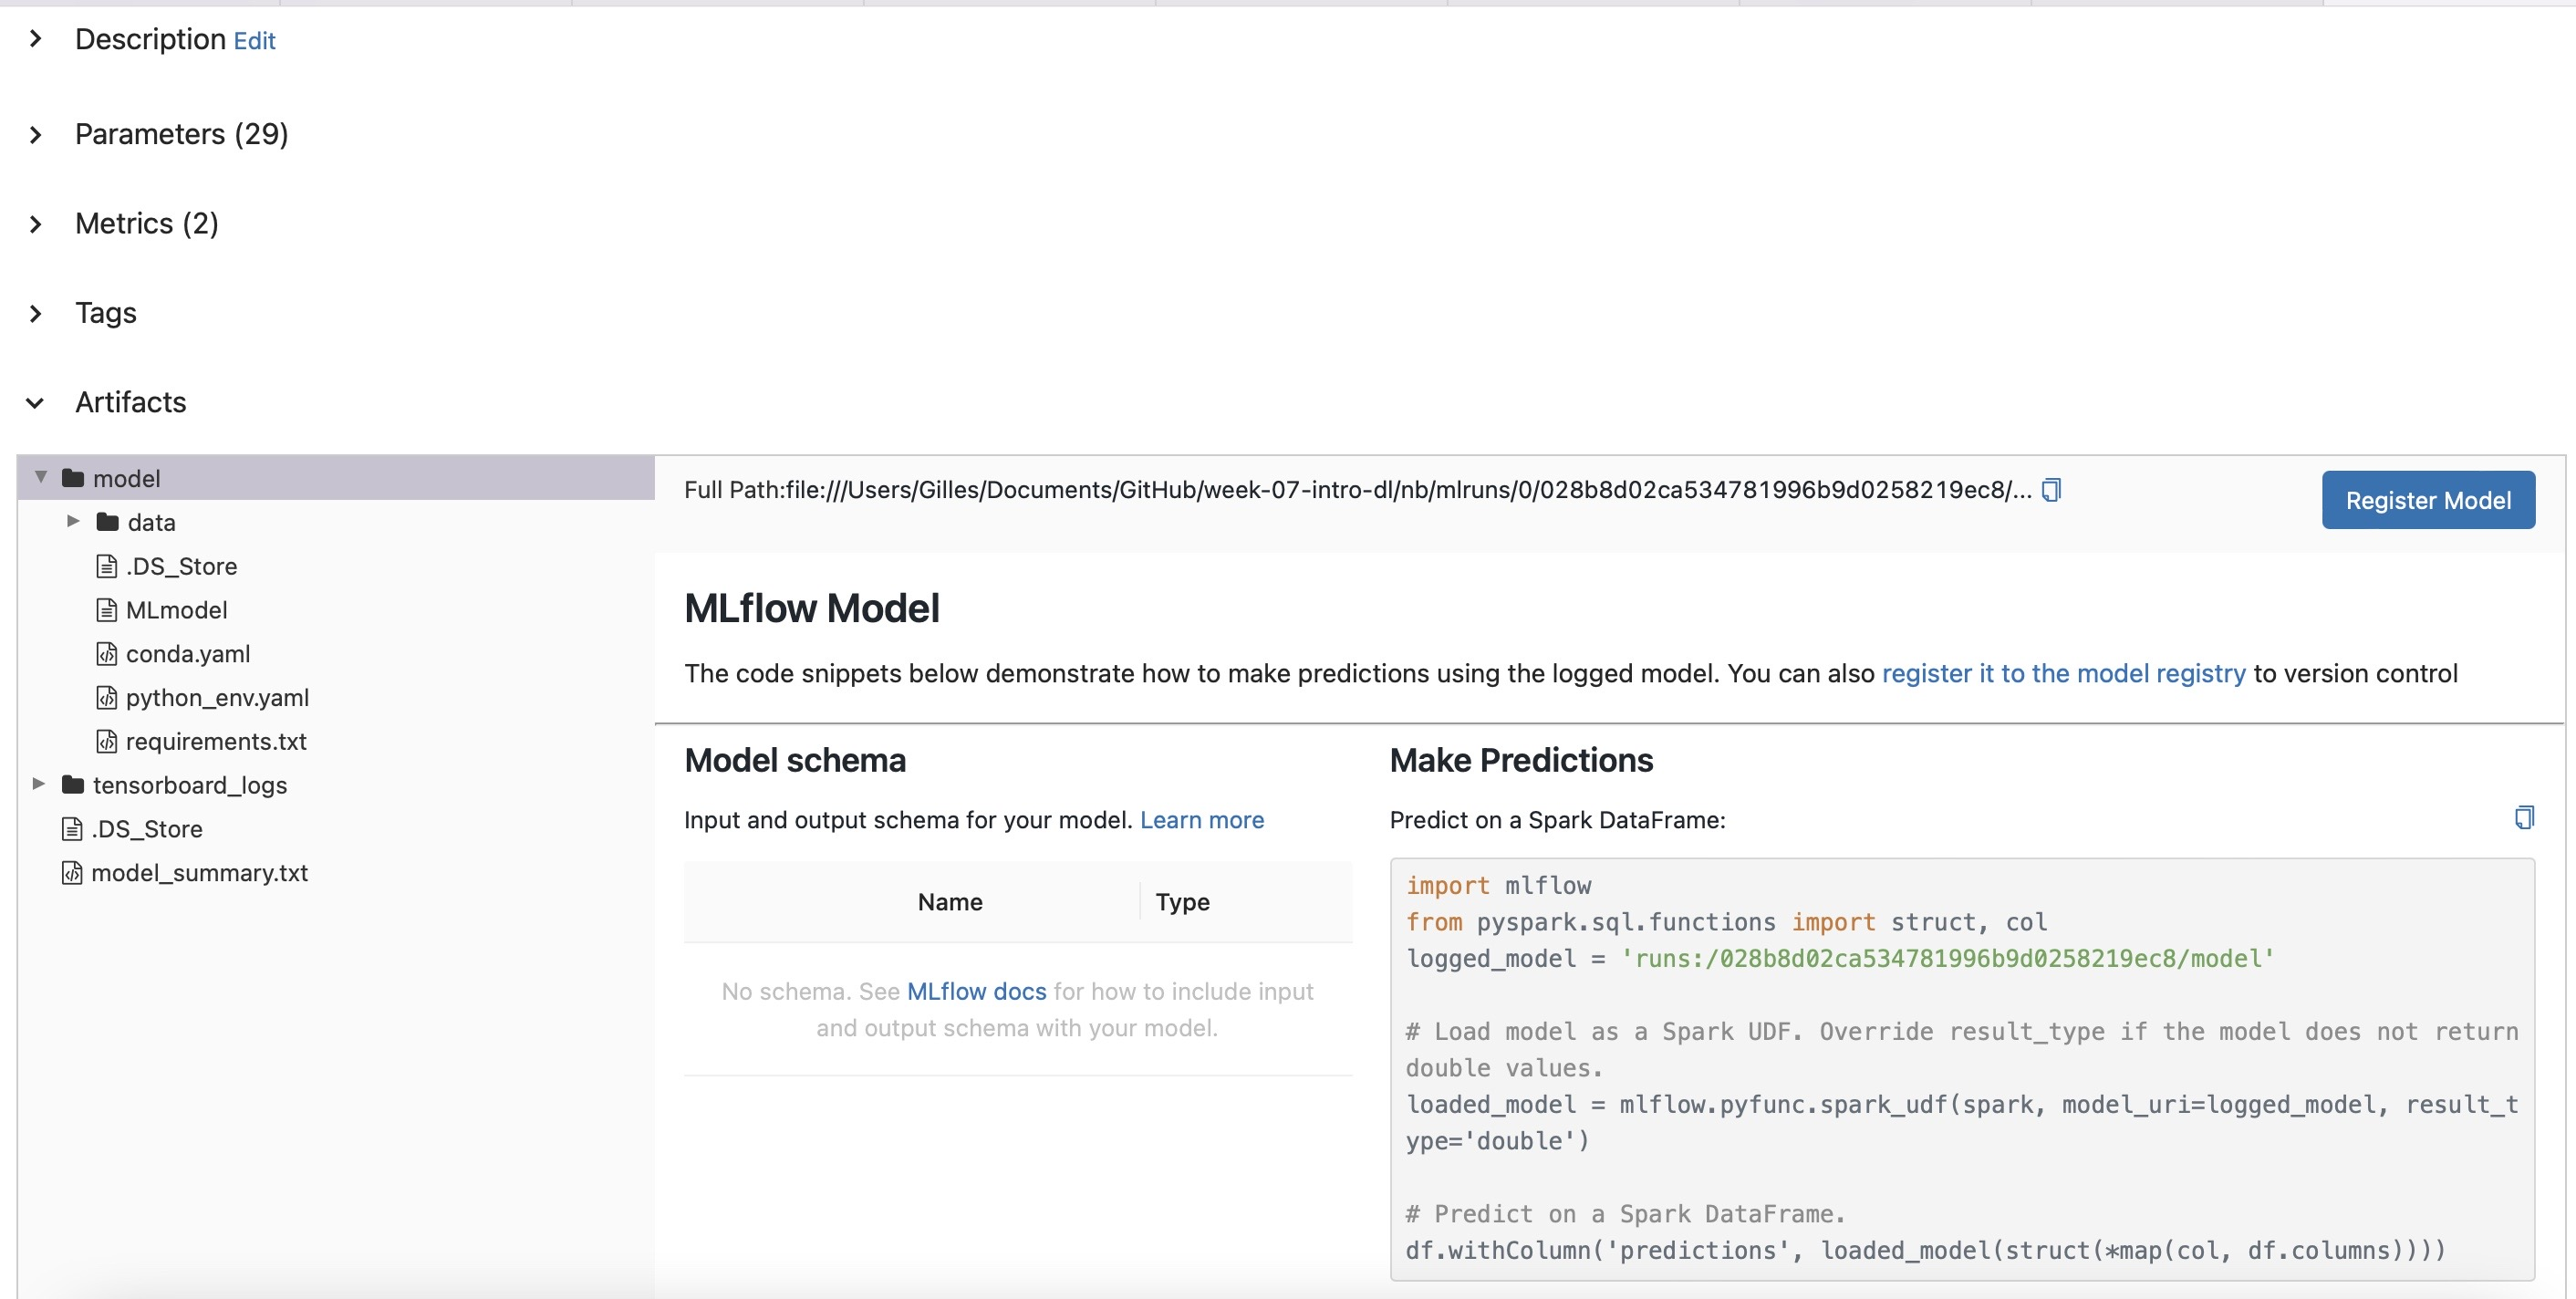

In [103]:
filename = '../img/mlflowexp2.jpg'
display(Image(filename=filename))

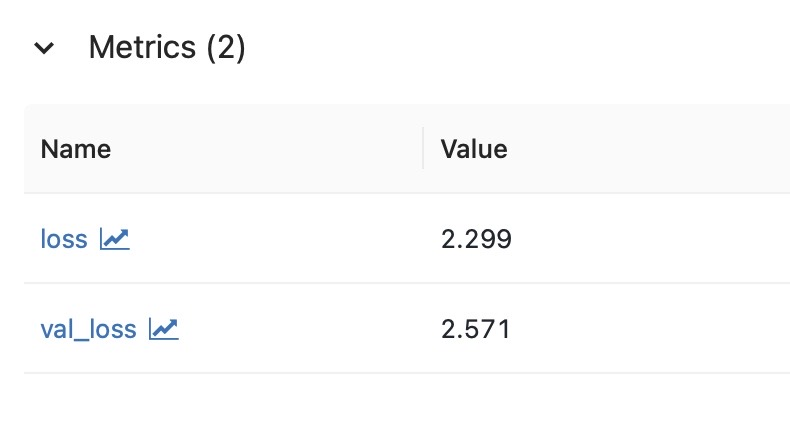

In [104]:
filename = '../img/mlflowexp3.jpg'
display(Image(filename=filename))

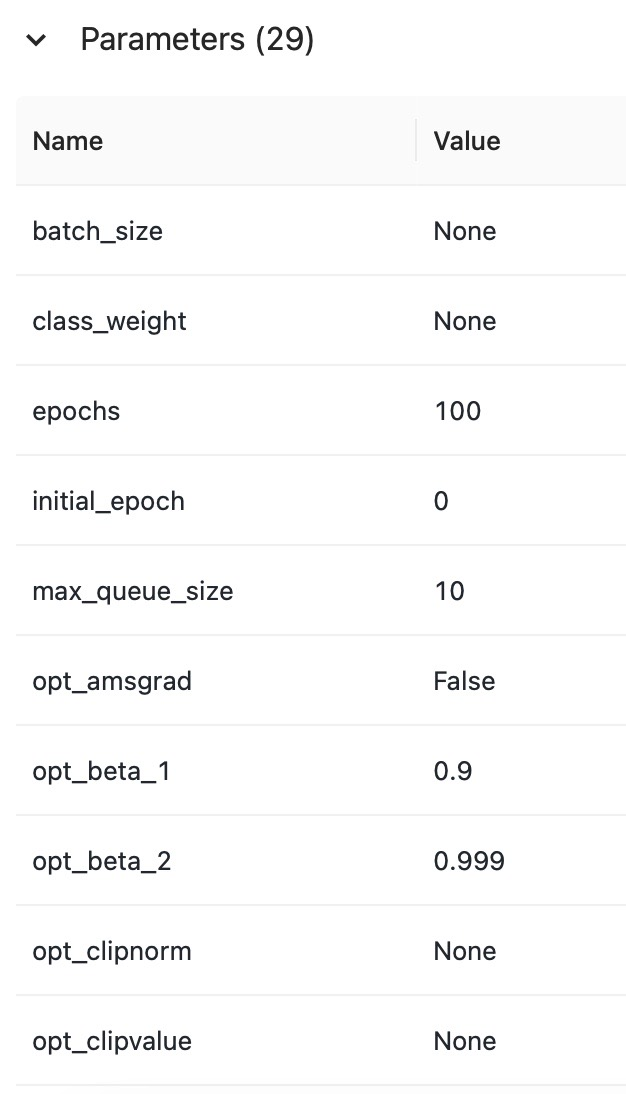

In [106]:
filename = '../img/mlfowexp4.jpg'
display(Image(filename=filename))

In [ ]:
#http://127.0.0.1:5000/#/experiments/0/runs/028b8d02ca534781996b9d0258219ec8

In [100]:
# stop the kernel
ngrok.kill()

NameError: name 'ngrok' is not defined

# Task 8 - AutoML with TPOT 🫖

1. Instantiate and train a TPOT auto-ML regressor.

  The parameters are set fairly arbitrarily (if time permits, you shall experiment with different sets of parameters after reading [what each parameter does](http://epistasislab.github.io/tpot/api/#regression)). Use these parameter values:

  `generations`: 10

  `population_size`: 40

  `scoring`: negative mean absolute error; read more in [scoring functions in TPOT](http://epistasislab.github.io/tpot/using/#scoring-functions)

  `verbosity`: 2 (so you can see each generation's performance)

  The final line with create a Python script tpot_products_pipeline.py with the code to create the optimal model found by TPOT.

In [168]:
%%time
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=10, 
                     population_size=40,
                     scoring=None, # YOUR CODE HERE scoring = 'f1' does not seem to do anything better
                     verbosity=2,
                     random_state=42)
tpot.fit(train_features, train_labels)
print(f"Tpop score on test data: {tpot.score(test_features, test_labels):.2f}")
tpot.export('tpot_mpg_pipeline.py')

Optimization Progress:   0%|          | 0/440 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -8.077745295810276

Generation 2 - Current best internal CV score: -8.077745295810276

Generation 3 - Current best internal CV score: -8.077745295810276

Generation 4 - Current best internal CV score: -8.00800302618326

Generation 5 - Current best internal CV score: -8.00800302618326

Generation 6 - Current best internal CV score: -7.827227772486582

Generation 7 - Current best internal CV score: -7.82722777248655

Generation 8 - Current best internal CV score: -7.82722777248655

Generation 9 - Current best internal CV score: -7.82722777248655

Generation 10 - Current best internal CV score: -7.827227772486549

Best pipeline: LassoLarsCV(ExtraTreesRegressor(MaxAbsScaler(VarianceThreshold(input_matrix, threshold=0.0005)), bootstrap=True, max_features=0.9500000000000001, min_samples_leaf=14, min_samples_split=6, n_estimators=100), normalize=True)
Tpop score on test data: -7.40
CPU times: user 10min 19s, sys: 7.97 s, total: 10min 27s
Wall ti

sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.


In [117]:
import sklearn.metrics
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [124]:
sklearn.metrics.get_scorer('f1')

make_scorer(f1_score, average=binary)

In [136]:
dataset.head(2)

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   

   Model Year  Europe  Japan  USA  
0          70       0      0    1  
1          70       0      0    1

2. Examine the model pipeline that TPOT regressor offers. If you see any model, function, or class that are not familiar, look them up! 

  Note: There is randomness to the way the TPOT searches, so it's possible you won't have exactly the same result as your classmate. 

In [169]:
cat tpot_mpg_pipeline.py

import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LassoLarsCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MaxAbsScaler
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: -7.827227772486549
exported_pipeline = make_pipeline(
    VarianceThreshold(threshold=0.0005),
    MaxAbsScaler(),
    StackingEstimator(estimator=ExtraTree

3. Take the appropriate lines (e.g., updating path to data and the variable names) from `tpot_mpg_pipeline.py` to build a model on our training set and make predictions on the test set. 
Save the predictions as `y_pred`, and compute appropriate evaluation metric. 
You may find that for this simple data set, the neural network we built outperforms the tree-based model, yet note it is not a conclusion that we can generalize for all tabular data. 

In [170]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LassoLarsCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MaxAbsScaler
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

In [171]:
####tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
tpot_data = dataset
features = tpot_data.drop('MPG', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['MPG'], random_state=42)

exported_pipeline = make_pipeline(
    VarianceThreshold(threshold=0.0005),
    MaxAbsScaler(),
    StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=True, max_features=0.9500000000000001, min_samples_leaf=14, min_samples_split=6, n_estimators=100)),
    LassoLarsCV(normalize=True)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [155]:
results

array([28.283, 23.142, 34.006, 28.283, 28.23 , 28.283, 13.798, 34.006,
       18.863, 28.283, 13.798, 23.142, 17.272, 28.283, 23.142, 28.23 ,
       23.142, 34.006, 34.006, 28.23 , 23.142, 34.006, 34.006, 13.798,
       28.283, 23.142, 23.142, 18.863, 28.283, 28.283, 13.798, 18.863,
       18.863, 34.006, 13.798, 34.006, 13.798, 28.283, 13.798, 13.798,
       13.798, 28.283, 34.006, 28.283, 13.798, 13.798, 18.863, 34.006,
       28.283, 28.283, 13.798, 23.142, 23.142, 28.23 , 18.863, 18.863,
       18.863, 18.863, 23.142, 23.142, 13.798, 18.863, 28.23 , 23.142,
       23.142, 28.283, 23.142, 28.283, 18.863, 13.798, 28.283, 13.798,
       23.142, 23.142, 18.863, 28.283, 13.798, 13.798, 23.142, 18.863,
       23.142, 23.142, 13.798, 34.006, 17.272, 34.006, 28.23 , 18.863,
       18.863, 18.863, 28.23 , 34.006, 34.006, 28.23 , 18.863, 23.142,
       23.142, 13.798])

In [154]:
testing_target

79     26.0
276    21.6
248    36.1
56     26.0
393    27.0
       ... 
370    31.0
252    19.2
211    16.5
76     18.0
105    13.0
Name: MPG, Length: 98, dtype: float64

In [156]:
pd.DataFrame(list(results))

0
0   28.283333
1   23.142222
2   34.005970
3   28.283333
4   28.230435
..        ...
93  28.230435
94  18.862745
95  23.142222
96  23.142222
97  13.798246

[98 rows x 1 columns]

In [157]:
results2 = pd.DataFrame(list(results))

In [159]:
testing_target2 = pd.DataFrame(testing_target)

In [177]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print('rsquare: ',r2_score(results, testing_target))
print('meanabsoluteError: ',mean_absolute_error(testing_target, results))
test_results['ExtraTree']=mean_absolute_error(testing_target, results)

rsquare:  0.879077713080702
meanabsoluteError:  1.8407450367071052


# Task 9 - Model Explainability

Last week, we introduced model explainability with SHAP and will continue to incorporate it as part our model output this week.  You can use the [Kernel Explainer](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html) for explainability of both the Neural Networks and the TPOT classifier.  

In [109]:
'''
copied from Explainer
#explainer = shap.KernelExplainer(f, X.iloc[:50,:])
#shap_values = explainer.shap_values(X.iloc[299,:], nsamples=500)
#shap.force_plot(explainer.expected_value, shap_values, X_display.iloc[299,:])
'''

import shap
explainer = shap.KernelExplainer(lambda x: dnn_model.predict(x).flatten(),train_features.iloc[:50,:])
shap_values = explainer.shap_values(test_features)
shap.initjs()
shap.force_plot(explainer.expected_value, np.array(shap_values), test_features)

# shows all explanations

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/78 [00:00<?, ?it/s]

797/797 [==============================] - 1s 1ms/step


In [110]:
shap.initjs()
shap.force_plot(explainer.expected_value, np.array(shap_values), test_features)

In [111]:
explainer = shap.KernelExplainer(lambda x: dnn_model.predict(x).flatten(),train_features.iloc[:50,:])
shap_values = explainer.shap_values(test_features.iloc[0,:])
shap.initjs()
shap.force_plot(explainer.expected_value, np.array(shap_values), test_features.iloc[0,:])
# shows the first explanation

797/797 [==============================] - 2s 2ms/step


# Task 10 - Taking it to the Next Level! 📶

Let's take our models and make a model comparison demo like we did last week, but this time you're taking the lead!  
    
1. Save your training dataset as a CSV file so that it can be used in the Streamlit app.
1. Build a results DataFrame and save it as a CSV so that it can be used in the Streamlit app.
1. In Tab 1 - Raw Data:
* Display your training dataset in a Streamlit DataFrame (`st.DataFrame`).
* Build 1-2 interactive Plotly visualizations that explore the dataset (correlations, scatterplot, etc.)
2. In Tab 2 - Model Results:
* Display your performance metrics appropriately using 2-3 metrics for model comparison.
3. In Tab 3 - Model Explainability:
* Make local and global explainability plots to compare two models at a time side-by-side.  [Here](https://www.kaggle.com/code/elsa155026/uciheart-kernel-shap-and-interactive-visualization/notebook) is a good example if how to create some different explainability plots using Plotly.

In [178]:
test_results

{'linear_model': 2.4612009525299072,
 'dnn_model': 1.6599880456924438,
 'reloaded': 1.6599880456924438,
 'dnn_model2': 2.289334297180176,
 'ExtraTree': 1.8407450367071052}

In [179]:
!ls

dnn_model                               imports.ipynb
dnn_model2                              mlruns
fuel-efficiency-prediction-streamlit.py requirements.txt
fuel_efficiency.ipynb                   tpot_mpg_pipeline.py
fuel_efficiency_sunday.ipynb


In [180]:
cat fuel-efficiency-prediction-streamlit.py

import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import streamlit as st
import streamlit.components.v1 as components
from PIL import Image

# Add and resize an image to the top of the app
img_fuel = Image.open("../img/fuel_efficiency.png")
st.image(img_fuel, width=700)

st.markdown("<h1 style='text-align: center; color: black;'>Fuel Efficiency</h1>", unsafe_allow_html=True)

# Import train dataset to DataFrame
train_df = pd.read_csv("../dat/train.csv.gz", compression="gzip")
model_results_df = pd.read_csv("../dat/model_results.csv")

# Create sidebar for user selection
with st.sidebar:
    # Add FB logo
    st.image("https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" )    

    # Available models for selection

    # YOUR CODE GOES HERE!
    models = ["DNN", "TPOT"]

    # Add model select boxes
    model1_select = st.selectbox(
        "Choose Model 1:",
        (models)
    )
    
    # Remove selec

In [184]:
test_results

{'linear_model': 2.4612009525299072,
 'dnn_model': 1.6599880456924438,
 'reloaded': 1.6599880456924438,
 'dnn_model2': 2.289334297180176,
 'ExtraTree': 1.8407450367071052}

In [187]:
import csv
dataset.to_csv("../dat/train.csv")
dfresults = pd.DataFrame(test_results.items(), columns=['Model', 'Mean Absolute Error'])
dfresults.to_csv("../dat/model_results.csv")

In [190]:
!python fuel-efficiency-prediction-streamlit.py

Traceback (most recent call last):
  File "/Users/Gilles/Documents/GitHub/week-07-intro-dl/nb/fuel-efficiency-prediction-streamlit.py", line 2, in <module>
    import plotly.express as px
ModuleNotFoundError: No module named 'plotly'


In [191]:
!pip install plotly

  Using cached plotly-5.13.0-py2.py3-none-any.whl (15.2 MB)
  Using cached tenacity-8.1.0-py3-none-any.whl (23 kB)


In [192]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 5.6 MB/s eta 0:00:0000:0100:01
  Using cached pydeck-0.8.0-py2.py3-none-any.whl (4.7 MB)
  Using cached Pympler-1.0.1-py3-none-any.whl (164 kB)
  Using cached validators-0.20.0.tar.gz (30 kB)
  Preparing metadata (setup.py) ... done
  Using cached cachetools-5.3.0-py3-none-any.whl (9.3 kB)
  Using cached tzlocal-4.2-py3-none-any.whl (19 kB)
  Using cached semver-2.13.0-py2.py3-none-any.whl (12 kB)
  Using cached blinker-1.5-py2.py3-none-any.whl (12 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 kB 3.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.8/982.8 kB 4.4 MB/s eta 0:00:00a 0:00:01
  Using cached altair-4.2.2-py3-none-any.whl (813 kB)
  Using cached Pygments-2.14.0-py3-none-any.whl (1.1 MB)
  Using cached markdown_it_py-2.1.0-py3-none-any.whl (84 kB)
  Using cached pytz_deprecation_shim-0.1.0.post0-py2.py3-none-any.whl (15 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)
  Usin

In [ ]:
# type a terminal !streamlit run fuel-efficiency-prediction-streamlit.py 

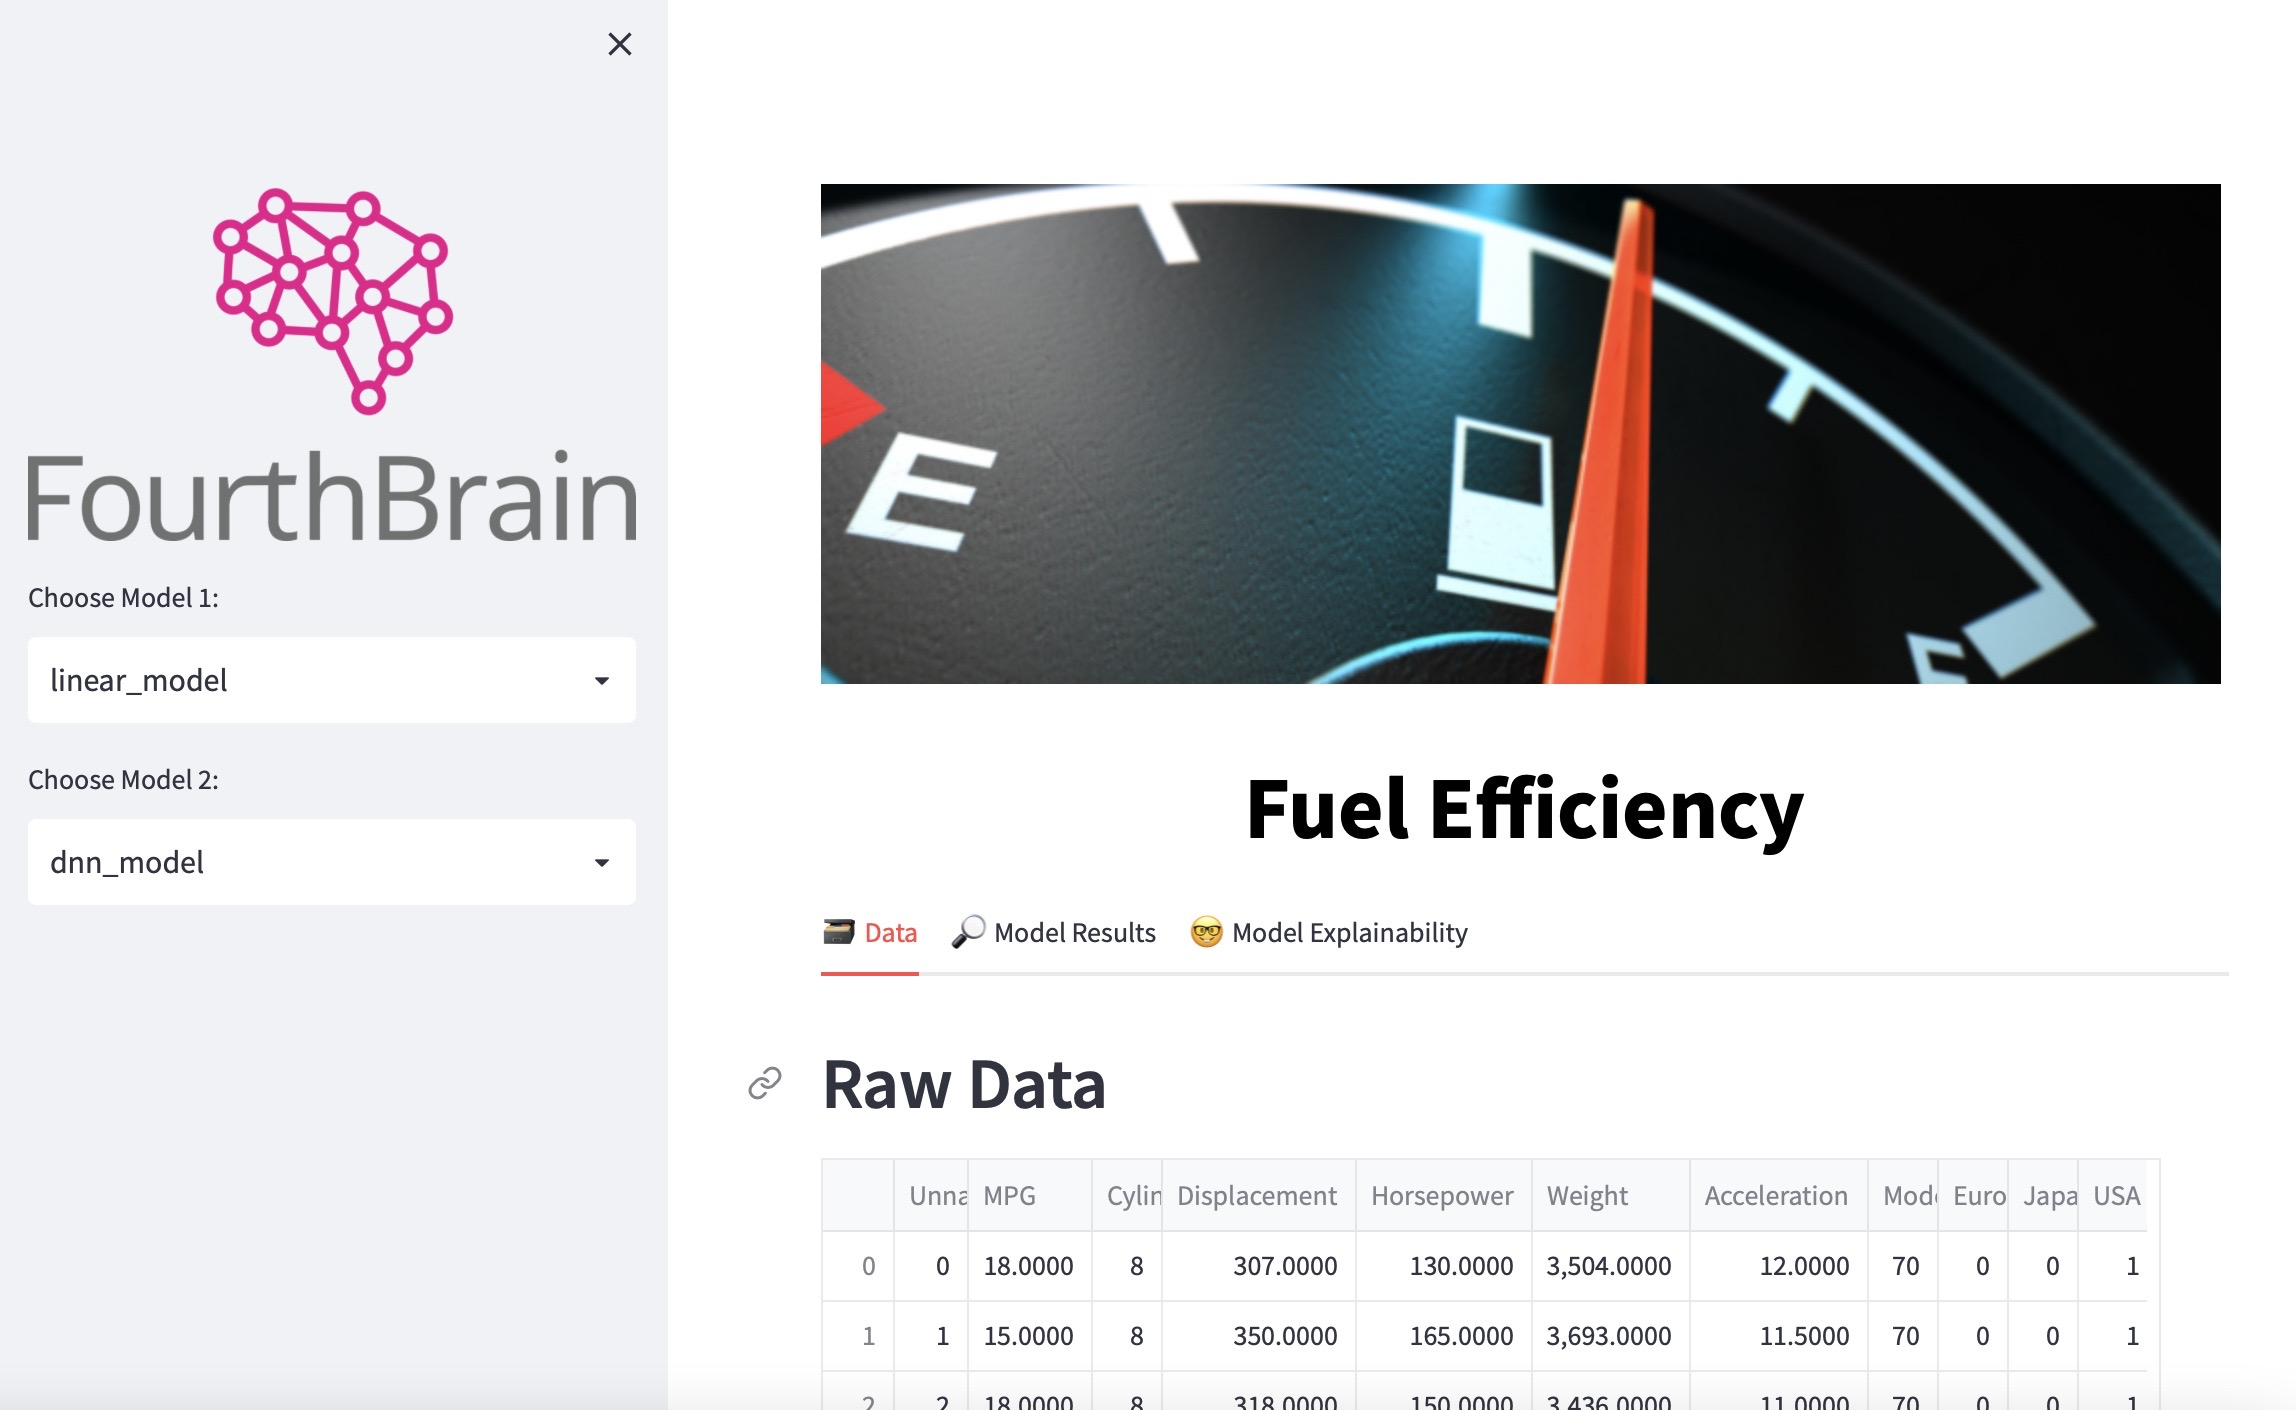

In [3]:
from IPython.display import Image, display
# change the filename to wherever you downloaded/uploaded the file
filename = '../img/streamlit1.jpg'
display(Image(filename=filename))

## Questions of the week:

1/ Interview Readiness: <br>
What is Normalization and how does Normalization make training a model more stable?
<br>
<br>
Normalization adjusts the attributes of a data set to common scale across the data. As all attributes have the same type of values none of them have more influence on a model as others and this helps the model converge faster and better

2/Interview Readiness
What are loss and optimizer functions and how do they work?
<br><br>
The success of a maching learning model is measured with a cost function reporting a difference between what is expected and what is predicted. This difference is knicknamed a loss. In order to decrease the loss (sometimes increase the gain) the parameters of the model are changed by what is called an optimizer function
<br><br>
What is Gradient Descent and how does it work?
<br><br>
Gradient Descent is one of those optimizer. It adjust the parameters of a model by reducing their values by the value of the derivative of the loss function applied to the variable and multiplying this derivative value by a parameter called the learning rate

3/ Interview Readiness: <br>
What is an activation function?
What are the outputs of the following activation functions: ReLU, Softmax Tanh, Sigmoid<br><br>
An activation function is a function that enables to differentiate if there is signal coming out of a neural network point or not. The name above are typically S shape curved functions (middle of the S is at the x=0,y=0 point for tanh) and depending if it on the left or the right it has a negative effect or a positive effect. <BR>
   tanh really looks like an S <br>
    sigmoid is a s with lower value 0 and higher value 1<br>
    relu is half a S of tanh just keeping the positive part - some expanded relu 
   can be derivated at 0 so can sense a negative or null effect <br>
    Softmax function is a bit different because it takes an list of values and convert them in another list that has a a sum of 1. So the highest value is likely the one people are looking for.



4/ Algorithm Understanding
What is the TPOT algorithm and how does it work? 
It is a search engine that try all type of algorithm on a data set in order to give the best prediction. It returns the code to run to predict values
What does TPOT stand for?

# Additional Resources

- [Tensorflow playground](https://playground.tensorflow.org/) for an interactive experience to understand how nueral networkds work.

- [An Introduction to Deep Learning for Tabular Data](https://www.fast.ai/2018/04/29/categorical-embeddings/) covers embeddings for categorical variables. 

- [Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/) demonstrates using `class_weight` to handle imbalanced classification problems. 

# Acknowledgement and Copyright

##### Acknowledgement

This notebook is adapted from [tensorflow/keras tuorial - regression](https://www.tensorflow.org/tutorials/keras/regression)

##### Copyright 2018 The TensorFlow Authors.

@title Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

@title MIT License

Copyright (c) 2017 François Chollet

Permission is hereby granted, free of charge, to any person obtaining a
copy of this software and associated documentation files (the "Software"),
to deal in the Software without restriction, including without limitation
the rights to use, copy, modify, merge, publish, distribute, sublicense,
and/or sell copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
DEALINGS IN THE SOFTWARE.